In [1]:
# Import necessary libraries 

import time
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import jenkspy
import numpy as np
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
from datetime import datetime
import scipy.stats as stats
from datetime import date
from datetime import datetime
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.neighbors import NearestNeighbors
from s_dbw import S_Dbw
import sklearn
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering # For HAC clustering

# Scraping libraries
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

import google.oauth2.credentials
import os
import pickle
 
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request


In [2]:
# Download stopwords from nltk library

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gparu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Extraction using YouTube API
Setting up the driver and configure the link scraping method.

In [ ]:
#setting up a driver
driver = webdriver.Chrome('C:/Users/gparu/Downloads/chromedriver.exe')

def get_videos_link(channel, num_of_vid, driver):
    '''
    Function to get a certain number of video links from specified channel
    '''
    print(channel)
    #the driver enters the web page of the channel's playlist
    driver.get('https://www.youtube.com/{}/videos'.format(channel))
    
    #receiving the elements of the links of all the playlists
    play_elems = driver.find_elements_by_id("thumbnail")
    
    #generate new dataframe
    data = pd.DataFrame({
        'channel_link': [],
        'video_link': []
    })

    #receive the links of all playlists
    for ele in play_elems[:num_of_vid]:
        link = ele.find_element(By.XPATH,"..//*[@id='thumbnail']").get_attribute('href')

        # add results, video identifier are always the last 11 characters
        data = data.append({
            'channel_link': channel,
            'video_link': link[len(link)-11::]
        }, ignore_index=True)
        
    return data

## YouTube Data API Initialization

In [ ]:
CLIENT_SECRETS_FILE = "client_secret.json"

SCOPES = ['https://www.googleapis.com/auth/youtube.force-ssl']
API_SERVICE_NAME = 'youtube'
API_VERSION = 'v3'

def get_authenticated_service():
    credentials = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            credentials = pickle.load(token)
    #  Check if the credentials are invalid or do not exist
    if not credentials or not credentials.valid:
        # Check if the credentials have expired
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_console()
 
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(credentials, token)
 
    return build(API_SERVICE_NAME, API_VERSION, credentials = credentials)

if __name__ == '__main__':
    # When running locally, disable OAuthlib's HTTPs verification. When
    # running in production *do not* leave this option enabled.
    os.environ['OAUTHLIB_INSECURE_TRANSPORT'] = '0'
    service = get_authenticated_service()

## Video Data Extraction and Processing

In [ ]:
# Extract 25 videos from a channel and export it to CSV for analysis
today = date.today()

lds_channel_links = ['Channel A', 'Channel B']
video_data = pd.DataFrame({
    'channel_link': [],
    'video_link': []
})
    
for chan in lds_channel_links:
    video_data = video_data.append(get_videos_link(chan, 25, driver), ignore_index=True)

In [ ]:
# Sets of functions to retrieve video information

def get_all_info(config_request,request_type,fields=["textOriginal"],verbose=False):
    '''
    Extract information from API response based on the type, channel or video
    '''
    all_comments = []
    service = get_authenticated_service()
    if request_type == 'video':     
        results = service.videos().list(**config_request).execute()
        return get_all_info_from_results(results,fields=fields)
    elif request_type == 'channel':
        results = service.channels().list(**config_request).execute()
        return get_all_info_from_results(results,fields=fields)
    return(comments_this_page)

def get_all_info_from_results(results,fields=["textOriginal"]):
    '''
    Iterate from items array section from result JSON
    '''
    items = results.get("items")
    all_categories = []
    if(items):
        all_categories = [get_info_from_raw_result(item,fields=fields) for item in items]
    return(all_categories)

def get_info_from_raw_result(result,fields=["textOriginal"]):
    '''
    Retrieve values from specified tags
    '''
    topicCategories = []
    videoDuration = ""
    categoryID = ""
    title = ""
    description = ""
    published_data = ""
    channel = ""
    
    topicDetails = result.get("topicDetails")
    if(topicDetails):
        topicCategories = topicDetails.get("topicCategories") 
        
    contentDetails = result.get("contentDetails")
    if(contentDetails):
        videoDuration = contentDetails.get("duration")
        
    snippet = result.get("snippet")
    if (snippet):
        categoryID = snippet.get("categoryId")
        title = snippet.get("title")
        description = snippet.get("description")
        published_data = snippet.get("publishedAt")
        channel = snippet.get("channelId")
        tags = snippet.get("tags")
        
    data = {'link': result.get("id"),
        'channel': channel,
        'topic_categories': topicCategories,
        'duration': videoDuration,
        'categoryID': categoryID,
        'title': title,
        'description': description,
        'published_date':published_data,
        'tags': tags}

    return data

In [ ]:
# Build a master dataframe for video
video_df = pd.DataFrame(columns=['link', 'channel', 'topic_categories','duration','categoryID', 'title', 'description', 'published_date', 'tags']) # creates master dataframe 

# For each video, retrieve information and append to video master dataframe 
for link in video_data['video_link']:
    config_request = {"part":"snippet,contentDetails,topicDetails",
                      "id":link}
    
    all_videos = get_all_info(config_request,'video', fields=[],verbose=True)
    video_df = video_df.append(all_videos, ignore_index=True)

In [ ]:
def topic_extract(wikipedia_link, extract_type='video'):
    '''
    Rename all topic categories with prefix
    '''
    temp = wikipedia_link.split("/")[-1].lower()
    if extract_type == 'channel':
        return('chan_cat_'+temp)
    elif extract_type == 'video':
        return('vid_cat_'+temp)
    
def transform_categories(df):
    '''
    Transform categories into columns
    '''
    categories = pd.DataFrame()
    for i, row in df.iterrows():
        temp_df = pd.DataFrame([[1]*len(row['exracted_topic_categories'])], columns=row['exracted_topic_categories']) # creates master dataframe 
        categories= categories.append(temp_df, ignore_index=True)

    df = df.join(categories).fillna(0)
    return df

In [ ]:
#Make it to individual column is better perhaps? how tho
video_df['exracted_topic_categories'] = [[topic_extract(j, 'video') for j in i] for i in video_df['topic_categories']]

#Video duration in seconds 
video_df['duration_second'] = [pd.Timedelta(i.replace("T", "")).total_seconds() for i in video_df['duration']]

#Attempt to understand the description
video_df['description_cut'] = [remove_extra(i) for i in video_df['description']]

video_df['desc_polarity'] = video_df['description'].apply(lambda desc: TextBlob(desc).sentiment.polarity)
video_df['desc_subjectivity'] = video_df['description'].apply(lambda desc: TextBlob(desc).sentiment.subjectivity)

video_df['desc_cut_polarity'] = video_df['description_cut'].apply(lambda desc: TextBlob(desc).sentiment.polarity)
video_df['desc_cut_subjectivity'] = video_df['description_cut'].apply(lambda desc: TextBlob(desc).sentiment.subjectivity)

final_video_df = transform_categories(video_df)

## Comment Data Extraction and Processing
Use YouTube API to get necessary data on comments, including user, comment content, and date

In [ ]:
def extract_infos_from_comment(comment,fields=["textOriginal"]):
    # Extract information from snippet section
    snippet = comment.get("snippet")
    if(snippet):
        return( {key:snippet.get(key) for key in fields})
    else:
        return(None)

def get_comment_from_raw_result(result,fields=["textOriginal"]):
    # Extract each comment and its replies
    main_comment = None
    replies = []
    snippet = result.get("snippet")
    if(snippet):
        top_level_comment = snippet.get("topLevelComment")
        if(top_level_comment):
            main_comment = extract_infos_from_comment(top_level_comment,fields=fields)
        else:
            pass
    else:
        pass
    list_replies = result.get("replies")
    if(list_replies):
        comments = list_replies.get("comments")
        if(comments):
            for comment in comments:
                replies.append(extract_infos_from_comment(comment,fields=fields))
    dic = {"Main_comment":main_comment,"replies":replies}            
    return(dic)

def get_all_comments_from_results(results,fields=["textOriginal"]):
    # Select items array which has the comments information
    items = results.get("items")
    all_comments = [get_comment_from_raw_result(item,fields=fields) for item in items]
    return(all_comments)

def get_all_comments(config_request,fields=["textOriginal"],verbose=False):
    # Extract and append all comment information
    all_comments = []
    service = get_authenticated_service()
    try:
        results = service.commentThreads().list(**config_request).execute()
    except:
        return {"all_comments":[],"n_comments":[]}
    
    current_page = 0
    n_total_comments = 0
    while results:    
        current_page += 1
        if( verbose):
            print("parsing comments for page {}..".format(current_page))
        comments_this_page = get_all_comments_from_results(results,fields=fields)
        n_comments = len(comments_this_page)
        n_total_comments += n_comments
        if(verbose):
            print("Found {} comments on this page..".format(n_comments))
        all_comments.append(comments_this_page)
        if 'nextPageToken' in results:
                    config_request['pageToken'] = results['nextPageToken']
                    results = service.commentThreads().list(**config_request).execute()
        else:
            break
    dic = {"all_comments":all_comments,"n_comments":n_total_comments}
    return(dic)

In [ ]:
# Build a master dataframe for comment
comment_df = pd.DataFrame(columns=['video_id','comment','author_name','timestamp','likes','reply_flag', 'author_id']) # creates master dataframe 

# Extract comments from each video and append result to main comment dataframe
for link in final_video_df['link']:
    print("Fetching comments from link {}".format(link))
    config_request = {"part":"id,snippet,replies",
                      "order":"time",
                      "videoId":link}

    fields = ["textOriginal","publishedAt",'videoId','authorDisplayName','likeCount', 'authorChannelId']
    all_comments = get_all_comments(config_request,fields=fields)
                                    
    ## Loop through output##
    comments_temp = []
    comment_time_temp = []
    video_id_temp = []
    comment_author_temp = []
    like_count_temp = []
    reply_flag_temp = []
    author_channel_id_temp = []

    for full_list in all_comments["all_comments"]:
        for element in full_list:
            for j in element:
                if j == "Main_comment":
                    comments_temp.append(element["Main_comment"]["textOriginal"])
                    comment_time_temp.append(element["Main_comment"]["publishedAt"])
                    video_id_temp.append(element["Main_comment"]["videoId"])
                    comment_author_temp.append(element["Main_comment"]["authorDisplayName"])
                    like_count_temp.append(element["Main_comment"]["likeCount"])
                    author_channel_id_temp.append(element["Main_comment"]["authorChannelId"].get("value"))
                    reply_flag_temp.append(0)
                elif j  == "replies":
                    for reply in element["replies"]:
                        comments_temp.append(reply["textOriginal"])
                        comment_time_temp.append(reply["publishedAt"])
                        video_id_temp.append(reply["videoId"])
                        comment_author_temp.append(reply["authorDisplayName"])
                        like_count_temp.append(reply["likeCount"])
                        author_channel_id_temp.append(reply["authorChannelId"].get("value"))
                        reply_flag_temp.append(1)

    output_df = pd.DataFrame({'video_id': video_id_temp,
                  'comment': comments_temp,
                  'author_name': comment_author_temp,
                  'timestamp': comment_time_temp,
                  'likes': like_count_temp,
                  'reply_flag': reply_flag_temp,
                  'author_id': author_channel_id_temp})

    comment_df = comment_df.append(output_df, ignore_index=True)

In [ ]:
# Apply TextBlob sentiment analysis
comment_df['comment_polarity'] = comment_df['comment'].apply(lambda comment: TextBlob(comment).sentiment.polarity)
comment_df['comment_subjectivity'] = comment_df['comment'].apply(lambda comment: TextBlob(comment).sentiment.subjectivity)

comment_df.to_csv(r'comment_data_{}.csv'.format(today), index = False, header=True)

## Video and Comment Data
Merge video and comment based on the video ID. These merge is needed to compare some features between video and comment, namely published time.

In [ ]:
combined_vid_com_df=pd.merge(comment_df, final_video_df, left_on=  ['video_id'],
                   right_on= ['link'], 
                   how = 'left')
combined_vid_com_df.drop('video_id',axis=1)

# Calculate difference between comment and video metrics
combined_vid_com_df['comment_days_after_publish'] = [abs((datetime.strptime(row['published_date'][:10], "%Y-%m-%d") - datetime.strptime(row['timestamp'][:10], "%Y-%m-%d")).days) for i, row in combined_vid_com_df.iterrows()]
combined_vid_com_df['diff_vid_comment_polarity'] = combined_vid_com_df['comment_polarity'] - combined_vid_com_df['desc_polarity']
combined_vid_com_df['diff_vid_comment_subj'] = combined_vid_com_df['comment_subjectivity'] - combined_vid_com_df['desc_subjectivity']

# Calculate zscore for all comments per video - how different the sentiment of each comment compared to the average sentiment
for video_id in combined_vid_com_df['link'].unique():
    combined_vid_com_df.loc[combined_vid_com_df['link'] == video_id, 'vid_comment_zscore'] = stats.zscore(combined_vid_com_df.loc[combined_vid_com_df['link'] == video_id]['comment_polarity'])

In [ ]:
#Filter to get the videos a user has commented on
commented_categories = combined_vid_com_df.drop_duplicates(subset=['author_id', 'video_id'], keep='last', ignore_index=True)

vid_categories = ['author_id']
for i in combined_vid_com_df.columns:
    if i.startswith('vid_cat_'):
        vid_categories.append(i)

#Sum the number of categories the user have commented on
topic_viewer_df = pd.DataFrame(commented_categories[vid_categories].groupby(['author_id']).sum()).reset_index()
topic_viewer_df

In [ ]:
#Calculate average comment polarity score per video
comment_avg_polarity = pd.DataFrame(combined_vid_com_df[['link','comment_polarity','desc_polarity']].groupby('link').mean()).rename(columns = {'comment_polarity':'avg_comment_polarity', 'desc_polarity':'avg_desc_polarity'})
comment_avg_polarity

final_video_df = pd.merge(final_video_df, comment_avg_polarity, how = 'left', on='link')

In [ ]:
final_video_df.to_csv(r'video_data_{}.csv'.format(today), index = False, header=True)

## Viewer Subscription
Find what the viewers are watching outside Little Dot Studios. Some extractable information is topic categories, channel description, and published date. This will be the proxy to understand viewers behaviour outside LDS.

In [ ]:
def get_all_subscribed_channels(config_request,max_channel,fields=["textOriginal"],verbose=False):
    '''
    Get subscription list from all viewers
    '''
    temp_df = pd.DataFrame(columns=['viewer_link', 'sub_channel_name','sub_channel_link','sub_channel_pub_date'])

    service = get_authenticated_service()
    
    try:
        results = service.subscriptions().list(**config_request).execute()

        items = results.get("items")
        for item in items:
            snippet = item.get("snippet")
            temp_df = temp_df.append({
                'viewer_link': snippet.get("channelId"),
                'sub_channel_name': snippet.get("title"),
                'sub_channel_link': snippet.get("resourceId").get("channelId"),
                'sub_channel_pub_date': snippet.get("publishedAt")
            }, ignore_index=True)
    except: 
        temp_df = temp_df.append({
            'viewer_link': config_request.get('channelId')
        }, ignore_index=True)
        
    return(temp_df)

# Create a master dataframe for viewer subscription
viewer_subscription = pd.DataFrame(columns=['viewer_link', 'sub_channel_name','sub_channel_link','sub_channel_pub_date'])

for link in comment_12['author_id'].unique()[2000:]:
    config_request = {"part":"snippet","channelId":link,"maxResults": 50}
    
    subscribed_channels = get_all_subscribed_channels(config_request,'video', fields=[],verbose=True)
    viewer_subscription = viewer_subscription.append(subscribed_channels, ignore_index=True)
    
# Export the result to CSV
viewer_subscription.to_csv(r'viewer_subscription_{}.csv'.format(today), index = False, header=True)

## Data Reading
Reading CSV from extracted comments, videos, and subscription data. Merge all comments into one dataframe and all videos into one dataframe

In [3]:
# New comment_df will be retrieved from comment_vader - polarity recalculated using VADER library

#comment_1 = pd.read_csv("comment_data_2021-06-23.csv")
#comment_2 = pd.read_csv("comment_data_2021-06-24.csv")
#comment_3= pd.read_csv("comment_data_2021-06-25.csv")
#comment_4 = pd.read_csv("comment_data_2021-06-25_2.csv")
#comment_5 = pd.read_csv("comment_data_2021-06-26.csv")
#comment_8 = pd.read_csv("comment_data_2021-06-28_2.csv")
#comment_9 = pd.read_csv("comment_data_2021-06-29.csv")
#comment_10 = pd.read_csv("comment_data_2021-06-30.csv")
#comment_11 = pd.read_csv("comment_data_2021-07-04.csv")
#comment_12 = pd.read_csv("comment_data_2021-07-05.csv")
#comment_13 = pd.read_csv("comment_data_2021-07-08.csv")
#comment_14 = pd.read_csv("comment_data_2021-07-09.csv")
#comment_15 = pd.read_csv("comment_data_2021-07-10.csv")

#comment_df = pd.concat([comment_1, comment_2, comment_3, comment_4, comment_5,
#                    comment_8, comment_9, comment_10, comment_11, comment_12,
#                    comment_13, comment_14, comment_15], axis=0)

# Vader is a library trained with social media data so it's reliable to analyse social media posts without heavy cleaning
# Able to detect emojis and sentiment-laden cases
# Just need to remove URL if any
def remove_url(text: str) -> str:
    url_pat = r'http[:\w./-]*|www[:\w./-?\d]*'
    m = re.sub(url_pat, '', text)
    return m

def vader_analyzer(doc):
    '''
    Measure polarity score using Vader analyzer
    '''
    analyzer = SentimentIntensityAnalyzer()
    df = pd.DataFrame(columns=['Sentiment'])
    # returns neg, neu, pos, compound sentiment for each sentence token
    df = df.append({'Sentiment': analyzer.polarity_scores(remove_url(doc))['compound']}, ignore_index=True)
    return df

# Amendment was done and exported to comment_df_vader.csv
#comment_df['comment_polarity'] = [vader_analyzer(str(i))['Sentiment'][0] for i in comment_df['comment']]
#comment_df.to_csv(r'comment_df_vader.csv', index = False, header=True)

# Reading modified comment data
comment_df = pd.read_csv("comment_df_vader.csv")

In [4]:
# New video_df will be retrieved from final_video_df

#video_1 = pd.read_csv("video_data_2021-06-23.csv")
#video_2 = pd.read_csv("video_data_2021-06-24.csv")
#video_3= pd.read_csv("video_data_2021-06-25.csv")
#video_4 = pd.read_csv("video_data_2021-06-25_2.csv")
#video_5 = pd.read_csv("video_data_2021-06-26.csv")
#video_8 = pd.read_csv("video_data_2021-06-28_2.csv")
#video_9 = pd.read_csv("video_data_2021-06-29.csv")
#video_10 = pd.read_csv("video_data_2021-06-30.csv")
#video_11 = pd.read_csv("video_data_2021-07-04.csv")
#video_12 = pd.read_csv("video_data_2021-07-05.csv")
#video_13 = pd.read_csv("video_data_2021-07-08.csv")
#video_14 = pd.read_csv("video_data_2021-07-09.csv")
#video_15 = pd.read_csv("video_data_2021-07-10.csv")

#video_df = pd.concat([video_1, video_2, video_3, video_4, video_5,
#                    video_8, video_9, video_10, video_11, video_12, 
#                    video_13, video_14, video_15], axis=0)

#video_df.head()

#video_df.to_csv(r'final_video_df.csv', index=False)
video_df = pd.read_csv('final_video_df.csv')
video_df.fillna(0, inplace=True)

channel_df = pd.read_csv('channels.csv')[['name', 'channel_link']]

video_df = pd.merge(video_df, channel_df, left_on='channel', right_on='channel_link', how='left')

def stringToList(tags):
    final = []
    splitTags = tags[1:-1].split(",")
    for i in splitTags:
        final.append(i.strip()[1:-1])
    return final

video_df['tags'] = video_df.apply(lambda x: stringToList(x['tags']), axis=1)
video_df

link                   channel  \
0    Js-QLGTFO9Y  UCu4XcDBdnZkV6-5z2f16M0g   
1    jR0GtSeV084  UCu4XcDBdnZkV6-5z2f16M0g   
2    OMz64QbqUYc  UCu4XcDBdnZkV6-5z2f16M0g   
3    mSQZD6nqtPU  UCu4XcDBdnZkV6-5z2f16M0g   
4    -DNng0Ca39s  UCu4XcDBdnZkV6-5z2f16M0g   
..           ...                       ...   
745  mTiloUSIjWk  UCV-yCAXMS-nWrHtORuDfSuQ   
746  l_RHzg7c6Sc  UCV-yCAXMS-nWrHtORuDfSuQ   
747  wn6D_aoECts  UCV-yCAXMS-nWrHtORuDfSuQ   
748  7ObYWL1LlyQ  UCV-yCAXMS-nWrHtORuDfSuQ   
749  vQgDdKviA8Q  UCV-yCAXMS-nWrHtORuDfSuQ   

                                      topic_categories  duration  categoryID  \
0                                                   []   PT57M7S           1   
1    ['https://en.wikipedia.org/wiki/Television_pro...  PT57M20S           1   
2                                                   []  PT54M36S           1   
3    ['https://en.wikipedia.org/wiki/Society', 'htt...   PT43M4S           1   
4                                                   []   PT1H21M           1   
..                                                 ...       ...         ...   
745                                                 []  PT47M44S          27   
746                                                 []  PT48M45S          27   
747                                                 []  PT48M43S          27   
748                                                 []  PT58M45S          27   
749                                                 []  PT48M37S          27   

                                                 title  \
0    Life Inside A Sweat Shop (Social Documentary) ...   
1    Britain's Toxic Body Culture: Dying For a Six ...   
2    Facebook Follies: When Social Media Takes Over...   
3    Shootouts & Snitches: The Brutal Gangs of Shef...   
4    The Last Coal Miners (Injustice Documentary) |...   
..                                                 ...   
745  The Meteoric Rise Of Julius Caesar | Tony Robi...   
746  What Caused The Collapse Of Ancient Sparta? | ...   
747  How The Spartan-Athenian Alliance Became Hosti...   
748  What Caused The Fall Of Ancient Egypt? | Immor...   
749  The True Origins Of The Spartan Soldiers | The...   

                                           description        published_date  \
0    Six young fashion lovers including young Stace...  2021-06-22T16:00:08Z   
1    Reggie investigates the extreme ways in which ...  2021-06-20T16:00:16Z   
2    "Facebook Follies" takes a look at the unexpec...  2021-06-19T16:00:19Z   
3    In 2008, a gang feud in Sheffield is provoked ...  2021-06-17T16:00:22Z   
4    Hard Coal: Last of the Bootleg Miners is a fea...  2021-06-15T16:00:00Z   
..                                                 ...                   ...   
745  Julius Caesar is one of the monumental figures...  2021-03-12T17:00:20Z   
746  The Spartans chronicles the rise and fall of o...  2021-03-09T18:00:10Z   
747  Athens, which had been allied with Sparta agai...  2021-03-02T18:00:13Z   
748  Joann discovers how Egypt's enemies exploited ...  2021-02-26T17:45:00Z   
749  The Spartan Warrior society is one of the most...  2021-02-23T18:00:30Z   

                                                  tags  \
0    [Real Stories, Real Stories Full Documentary, ...   
1    [Real Stories, Real Stories Full Documentary, ...   
2    [Real Stories, Real Stories Full Documentary, ...   
3    [Real Stories, Real Stories Full Documentary, ...   
4    [Real Stories, Real Stories Full Documentary, ...   
..                                                 ...   
745  [ancient history, classical history, ancient c...   
746  [ancient history, classical history, ancient c...   
747  [ancient history, classical history, ancient c...   
748  [ancient history, classical history, ancient c...   
749  [ancient history, classical history, ancient c...   

                             exracted_topic_categories  ...  \
0                                                   []  ...   
1                

In [5]:
video_categories = []
for i in video_df.columns:
    if i.startswith('vid_cat'):
        video_categories.append(i)
        
#For grouping down the line
video_categories.append('author_id')

In [6]:
# New viewer_subscription_df will be retrieved from final_viewer_subscription

#subscription_1 = pd.read_csv("viewer_subscription_2021-06-23.csv")
#subscription_2 = pd.read_csv("viewer_subscription_2021-06-24.csv")
#subscription_3= pd.read_csv("viewer_subscription_2021-06-25.csv")
#subscription_4 = pd.read_csv("viewer_subscription_2021-06-25_2.csv")
#subscription_5 = pd.read_csv("viewer_subscription_2021-06-26.csv")
#subscription_8 = pd.read_csv("viewer_subscription_2021-06-27_2.csv")
#subscription_9 = pd.read_csv("viewer_subscription_2021-06-29.csv")
#subscription_10 = pd.read_csv("viewer_subscription_2021-06-30.csv")
#subscription_11 = pd.read_csv("viewer_subscription_2021-07-04.csv")
#subscription_12 = pd.read_csv("viewer_subscription_2021-07-05.csv")
#subscription_13 = pd.read_csv("viewer_subscription_2021-07-08.csv")
#subscription_14 = pd.read_csv("viewer_subscription_2021-07-09.csv")
#subscription_15 = pd.read_csv("viewer_subscription_2021-07-10.csv")

#viewer_subscription_df = pd.concat([subscription_1, subscription_2, subscription_3, subscription_4, subscription_5,
#                    subscription_8, subscription_9, subscription_10, subscription_11, subscription_12, 
#                    subscription_13, subscription_14, subscription_15], axis=0)

#viewer_subscription_df.head()
#viewer_subscription_df.to_csv(r'final_viewer_subscription.csv', index=False)
viewer_subscription_df = pd.read_csv('final_viewer_subscription.csv')
viewer_subscription_df = viewer_subscription_df.dropna()
viewer_subscription_df.drop_duplicates(inplace=True)
viewer_subscription_df

viewer_link     sub_channel_name  \
2       UCE5rPlC0N1Hwv2MlkFvDH0A     Petey SmallBlock   
3       UCE5rPlC0N1Hwv2MlkFvDH0A  Uncle Tony's Garage   
4       UCE5rPlC0N1Hwv2MlkFvDH0A       Ana Psychology   
5       UCE5rPlC0N1Hwv2MlkFvDH0A           BS with TG   
6       UCE5rPlC0N1Hwv2MlkFvDH0A      Fireball Camaro   
...                          ...                  ...   
466118  UCavTTC85uQEMO8Tod1fEwBg            Be. Busta   
466119  UCavTTC85uQEMO8Tod1fEwBg           Latte ASMR   
466120  UCavTTC85uQEMO8Tod1fEwBg            ASMR katz   
466121  UCavTTC85uQEMO8Tod1fEwBg        Wolters World   
466122  UCavTTC85uQEMO8Tod1fEwBg                WIRED   

                sub_channel_link         sub_channel_pub_date  
2       UC2jQarGdgrzkEQvQyh6BMaA  2021-05-23T05:18:04.765382Z  
3       UC9SzQNYLqsPQGY_nbHogDDw  2019-09-03T06:07:53.114763Z  
4       UCOxhlNofmYH-MRC36TURUGw  2021-05-13T22:24:07.122485Z  
5       UCF3qRRtMqzeUOvUl5t9o48Q         2016-09-30T13:31:57Z  
6       UC8qfIJvXHIxO5Z65ilaVm3A  2021-04-18T09:54:10.615649Z  
...                          ...                          ...  
466118  UC-ir6MfYIuyvVJS_DhOhcJw         2017-02-21T05:18:40Z  
466119  UCQe2Y7V-C9bNMAcCJCBvzQQ  2018-03-29T15:52:26.713361Z  
466120  UC9e5SwxSnQsQqMKsiU61LZw  2020-08-18T17:57:18.886109Z  
466121  UCFr3sz2t3bDp6Cux08B93KQ  2020-06-12T21:39:07.453907Z  
466122  UCftwRNsjfRo08xYE31tkiyw  2018-10-04T14:06:41.277003Z  

[415707 rows x 4 columns]

## Viewer Data
Using existing information gathered from comment, video, and the combination of both, viewer dataframe will be created to get individual characteristics of each viewer who has commented on LDS video.

In [7]:
# Creates master viewer dataframe 
viewer_data = pd.DataFrame(columns=['author_id'])
viewer_data['author_id'] = comment_df['author_id'].unique()

# How many comments they have made from all dataset
total_comments = pd.DataFrame(comment_df['author_id'].value_counts().rename_axis('author_id').reset_index(name='total_comments'))
total_comments

viewer_data =pd.merge(viewer_data, total_comments, how = 'left')

# How many videos the user commented on
video_commented = comment_df.groupby(['author_id', 'video_id']).size()
video_commented = pd.DataFrame(video_commented.groupby(['author_id']).size().rename_axis('author_id').reset_index(name='total_videos_commented'))
viewer_data = pd.merge(viewer_data, video_commented, how = 'left', on='author_id')

# Average comments per video 
viewer_data['average_comments_per_video'] = viewer_data['total_comments'] / viewer_data['total_videos_commented']

# How many likes in total they have -> gauge popularity?
total_likes = pd.DataFrame(comment_df[['author_id', 'likes']].groupby(['author_id']).sum().rename_axis('author_id').reset_index()).rename(columns = {'likes':'total_comment_likes'})
total_likes

viewer_data = pd.merge(viewer_data, total_likes, on='author_id',
                   how = 'left')

# How many likes in average per comment -> another gauge popularity?
viewer_data['average_likes_per_comment'] = viewer_data['total_comment_likes'] / viewer_data['total_videos_commented']

# How many comments count as reply -> gauge their engagement with other viewers (popularity or interactivity?)
total_comment_as_replies = pd.DataFrame(comment_df[['author_id', 'reply_flag']].groupby(['author_id']).sum().rename_axis('author_id')).reset_index().rename(columns = {'reply_flag':'total_comments_as_reply'})
total_comment_as_replies

viewer_data =pd.merge(viewer_data, total_comment_as_replies, on='author_id',
                   how = 'left')

viewer_data['reply_ratio'] = viewer_data['total_comments_as_reply'] / viewer_data['total_comments']
viewer_data.head()

author_id  total_comments  total_videos_commented  \
0  UC61FXJS99rcSbHozBd01ELg               1                       1   
1  UCQIqgn2crQujvcjO_1LiqvQ               1                       1   
2  UCE5rPlC0N1Hwv2MlkFvDH0A               3                       2   
3  UCeW9X5_7MUdbRfteOe8oHaA               1                       1   
4  UCe0JQ2BOL_7RylIefI44R7Q               1                       1   

   average_comments_per_video  total_comment_likes  average_likes_per_comment  \
0                         1.0                    0                        0.0   
1                         1.0                    0                        0.0   
2                         1.5                   28                       14.0   
3                         1.0                    0                        0.0   
4                         1.0                    0                        0.0   

   total_comments_as_reply  reply_ratio  
0                        0     0.000000  
1                        0     0.000000  
2                        1     0.333333  
3                        0     0.000000  
4                        0     0.000000

### Average Statistics of Viewer - Video and Comment

In [8]:
combined_vid_com_df=pd.merge(comment_df, video_df, left_on=  ['video_id'],
                   right_on= ['link'], 
                   how = 'left')
combined_vid_com_df.drop('video_id',axis=1)

# Calculate zscore for all comments per video - how different the sentiment of each comment compared to the average sentiment
for video_id in combined_vid_com_df['link'].unique():
    combined_vid_com_df.loc[combined_vid_com_df['link'] == video_id, 'vid_comment_zscore'] = stats.zscore(combined_vid_com_df.loc[combined_vid_com_df['link'] == video_id]['comment_polarity'])

# Average statistics based on video and comment merged dataset
combined_vid_com_df['comment_days_after_publish'] = [abs((datetime.strptime(row['published_date'][:10], "%Y-%m-%d") - datetime.strptime(row['timestamp'][:10], "%Y-%m-%d")).days) for i, row in combined_vid_com_df.iterrows()]

average_stats_viewer_df = combined_vid_com_df[['author_id', 'comment_days_after_publish', 'vid_comment_zscore']].groupby(['author_id']).mean().reset_index()
average_stats_viewer_df.columns = ['author_id','avg_comment_days_after_publish','avg_vid_comment_zscore']

average_stats_viewer_df.fillna(0)

C:\Users\gparu\anaconda3\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


author_id  avg_comment_days_after_publish  \
0      UC--Az-GyV4yaNLCALdUUyGg                        1.000000   
1      UC--C6qPNUBk-rG6CcYEb_nA                        4.000000   
2      UC--D3Lls67TPt2KcT5Vspyg                       23.000000   
3      UC--DkOzfvmvWjhvUZJ5wcUg                        0.000000   
4      UC--LS_oTYmD4DNeKWR09i6A                        6.000000   
...                         ...                             ...   
46854  UCzzWDvR7KzG26uytF_FsLcQ                        2.333333   
46855  UCzz_xz32GQZonewlaUTI35A                       24.000000   
46856  UCzzbvMg2vec9JjSBRgknIBQ                        8.000000   
46857  UCzzfo4AuoRCd0kPzeHh2OFA                       10.000000   
46858  UCzzvQFT3TXlaonQb8djv9FQ                       39.000000   

       avg_vid_comment_zscore  
0                    1.360840  
1                   -1.383182  
2                   -1.036442  
3                   -1.629207  
4                    0.887212  
...                       ...  
46854                0.351666  
46855               -0.504589  
46856               -0.355278  
46857               -1.726050  
46858               -0.241274  

[46859 rows x 3 columns]

In [9]:
# Categories watched by a viewer
categories_viewer_df = combined_vid_com_df[video_categories].groupby(['author_id']).sum().reset_index()

### Combine All Viewer Dataset
Merge viewer data with average statistics and watched categories dataframes

In [10]:
viewer_data = pd.merge(viewer_data, average_stats_viewer_df, on='author_id', how = 'left')

viewer_data = pd.merge(viewer_data, categories_viewer_df, on='author_id', how = 'left')

In [11]:
viewer_data

author_id  total_comments  total_videos_commented  \
0      UC61FXJS99rcSbHozBd01ELg               1                       1   
1      UCQIqgn2crQujvcjO_1LiqvQ               1                       1   
2      UCE5rPlC0N1Hwv2MlkFvDH0A               3                       2   
3      UCeW9X5_7MUdbRfteOe8oHaA               1                       1   
4      UCe0JQ2BOL_7RylIefI44R7Q               1                       1   
...                         ...             ...                     ...   
46854  UCp9GZy7vL6gYpv64LucN1Mg               1                       1   
46855  UCt3yfa85RCP7b-QkYY92OSA               1                       1   
46856  UC3AQsP08aBzlMl12A4580ww               1                       1   
46857  UCDAqtZz7Ugs06CGjLmUya-Q               1                       1   
46858  UCsLWExyz_tQuTTwY6Heqvcw               1                       1   

       average_comments_per_video  total_comment_likes  \
0                             1.0                    0   
1                             1.0                    0   
2                             1.5                   28   
3                             1.0                    0   
4                             1.0                    0   
...                           ...                  ...   
46854                         1.0                    3   
46855                         1.0                   28   
46856                         1.0                    0   
46857                         1.0                    8   
46858                         1.0                    0   

       average_likes_per_comment  total_comments_as_reply  reply_ratio  \
0                            0.0                        0     0.000000   
1                            0.0                        0     0.000000   
2                           14.0                        1     0.333333   
3                            0.0                        0     0.000000   
4                            0.0                        0     0.000000   
...                          ...                      ...          ...   
46854                        3.0                        0     0.000000   
46855                       28.0                        0     0.000000   
46856                        0.0                        1     1.000000   
46857                        8.0                        0     0.000000   
46858                        0.0                        1     1.000000   

       avg_comment_days_after_publish  avg_vid_comment_zscore  ...  \
0                            1.000000               -1.729085  ...   
1                            1.000000                0.055088  ...   
2                            1.666667                0.060000  ...   
3                            1.000000                0.055088  ...   
4                            1.000000                1.073600  ...   
...                               ...                     ...  ...   
46854                        0.000000                0.075592  ...   
46855                        0.000000                0.883358  ...   
46856                       54.000000               -0.317714  ...   
46857                        0.000000                1.238874  ...   
46858                       20.000000                1.610820  ...   

       vid_cat_electronic_music  vid_cat_politics  vid_cat_basketball  \
0                           0.0               0.0                 0.0   
1                           0.0               0.0                 0.0   
2                           0.0               0.0                 0.0   
3                           0.0               0.0                 0.0   
4                           0.0               0.0                 0.0   
...                         ...               ...                 ...   
46854                       0.0               0.0                 0.0   
46855                       0.0               0.0                 0.0   
46856                       0.0      

## Tag Data

In [430]:
def get_tags(channel_name, tags):
    '''
    get n-grams that occur the most from tags array
    exclude the words from the channel name
    
    rank ngrams, choose only top 3 ranks, maximum 10 tags
    '''
    ADDITIONAL_STOPWORDS = channel_name.lower().split(" ")
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS + ['full', 'show', 'shows', 'topic']

    c_vec = CountVectorizer(stop_words=stopwords, ngram_range=(2,3))
    # matrix of ngrams
    
    try:
        ngrams = c_vec.fit_transform(tags)
    except:
        return pd.DataFrame({'ngram':[channel_name.lower()]})
    
    # count frequency of ngrams
    count_values = ngrams.toarray().sum(axis=0)
    # list of ngrams
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
                           ).rename(columns={0: 'frequency', 1:'ngram'})
    
    df_ngram['rank'] = df_ngram['frequency'].rank(method='min', ascending=0)
    return df_ngram[df_ngram['rank'] <= 3][:3]

def get_one_tag(channel_name, tags):
    '''
    get 1 n-gram that occur the most from tags array
    exclude the words from the channel name
    '''
    ADDITIONAL_STOPWORDS = channel_name.lower().split(" ")
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS + ['full' , 'show', 'shows', 'topic']

    c_vec = CountVectorizer(stop_words=stopwords, ngram_range=(2,3))
    # matrix of ngrams
    try:
        ngrams = c_vec.fit_transform(tags)
    except:
        return pd.DataFrame({'ngram':[channel_name.lower()]})
    
    # count frequency of ngrams
    count_values = ngrams.toarray().sum(axis=0)
    # list of ngrams
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
                           ).rename(columns={0: 'frequency', 1:'ngram'})

    df_ngram['rank'] = df_ngram['frequency'].rank(method='min', ascending=0)
    if df_ngram[df_ngram['rank'] == 1][:1]['ngram'][0] == 'documentary documentary':
        print(tags)
    return df_ngram[df_ngram['rank'] == 1][:1]

In [431]:
one_tag = pd.DataFrame(columns=['link', 'top_tags']) # creates master dataframe 
for i, j in video_df.iterrows():
    if j['tags'] != '0':
        top_tags = get_one_tag(j['name'], j['tags'])
        for x in top_tags['ngram']:
            one_tag = one_tag.append({
                'link':j['link'], 
                'top_tags':x}, ignore_index=True)

multiple_tags = pd.DataFrame(columns=['link', 'top_tags']) # creates master dataframe 
for i, j in video_df.iterrows():
    if j['tags'] != '0':
        top_tags = get_tags(j['name'], j['tags'])
        for x in top_tags['ngram']:
            multiple_tags = multiple_tags.append({
                'link':j['link'], 
                'top_tags':x}, ignore_index=True)

## Data Exploration

In [14]:
# Outliers removal
def remove_outliers(df_in, col_name):
    _, _, _, _, minimum, maximum = get_iqr_values(df_in, col_name)
    df_out = df_in.loc[(df_in[col_name] > minimum) & (df_in[col_name] < maximum)]
    return df_out

def get_iqr_values(df_in, col_name):
    median = df_in[col_name].median()
    q1 = df_in[col_name].quantile(0.025) # 25th percentile / 1st quartile
    q3 = df_in[col_name].quantile(0.975) # 7th percentile / 3rd quartile
    iqr = q3-q1 #Interquartile range
    minimum  = q1-1.5*iqr # The minimum value or the |- marker in the box plot
    maximum = q3+1.5*iqr # The maximum value or the -| marker in the box plot
    return median, q1, q3, iqr, minimum, maximum

### Sentiment Score

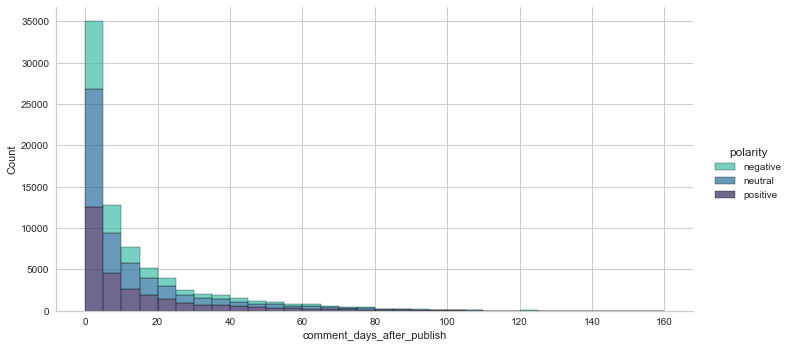

In [15]:
def polarity_label(pol):
    if pol > 0.3:
        return 'positive'
    elif pol < -0.3:
        return 'negative'
    else:
        return 'neutral'
    
time_polarity_df= combined_vid_com_df[['comment_days_after_publish', 'comment_polarity','author_id']]
time_polarity_df = remove_outliers(time_polarity_df, 'comment_days_after_publish')

time_polarity_df['polarity'] = [polarity_label(i) for i in time_polarity_df['comment_polarity']]

sns.displot(x='comment_days_after_publish', data=time_polarity_df, hue='polarity', binwidth=5, multiple='stack', height=5, aspect=2, palette='mako_r')

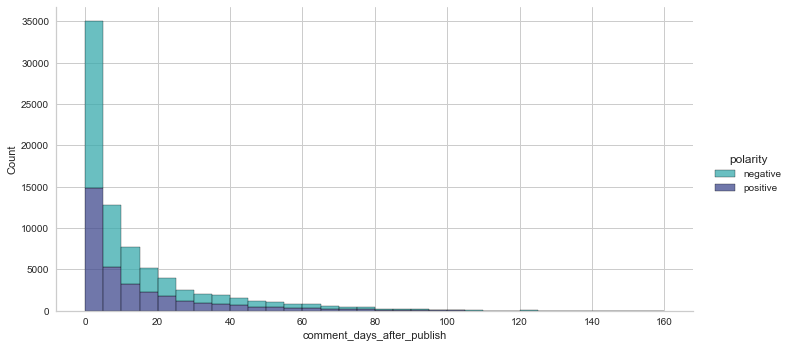

In [16]:
def polarity_label_2(pol):
    if pol > 0:
        return 'positive'
    else:
        return 'negative'
    
time_polarity_df= combined_vid_com_df[['comment_days_after_publish', 'comment_polarity','author_id']]
time_polarity_df = remove_outliers(time_polarity_df, 'comment_days_after_publish')

time_polarity_df['polarity'] = [polarity_label_2(i) for i in time_polarity_df['comment_polarity']]

sns.displot(x='comment_days_after_publish', data=time_polarity_df, hue='polarity', binwidth=5, multiple='stack', height=5, aspect=2, palette='mako_r')

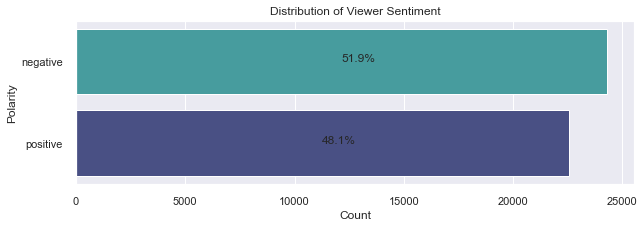

In [17]:
def pol_label(polarity):
    if polarity < 0:
        return 'negative'
    else:
        return 'positive'
      
temp = viewer_data[['avg_vid_comment_zscore', 'author_id']].copy()
temp['pol'] = [pol_label(i) for i in temp['avg_vid_comment_zscore']]

sns.set(rc = {'figure.figsize':(10,3)})
ax = sns.countplot(y="pol", data=temp, palette='mako_r')
plt.title('Distribution of Viewer Sentiment')
plt.xlabel('Count')
plt.ylabel('Polarity')

total = len(temp)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

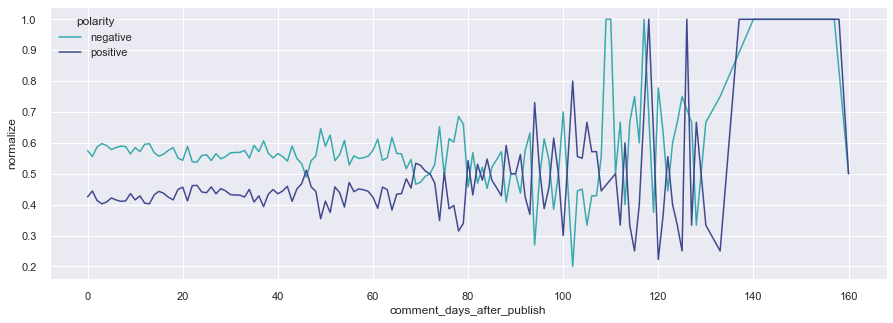

In [18]:
a = time_polarity_df[['comment_days_after_publish', 'polarity', 'author_id']].groupby(['comment_days_after_publish', 'polarity']).count()
a.reset_index(inplace=True)
b = time_polarity_df[['comment_days_after_publish', 'author_id']].groupby(['comment_days_after_publish']).count()
c = pd.merge(a, b, on= 'comment_days_after_publish',
                   how = 'left')
c['normalize'] = c['author_id_x'] / c['author_id_y']

sns.set(rc = {'figure.figsize':(15,5)})
sns.lineplot(x='comment_days_after_publish', y='normalize', data=c, hue='polarity', palette='mako_r')

### Each feature distribution

In [338]:
def distribute_plot(df, col, aspect, binwidth):
    '''
    Use seaborn to plot the distribution of specificed column
    '''
    filtered_df = df[[col,'author_id']]
    filtered_df = remove_outliers(filtered_df, col)
    sns.displot(x=col, data=filtered_df, binwidth=binwidth, aspect=aspect)
    
def wo_distribute_plot(df, col, aspect, binwidth):
    '''
    Use seaborn to plot the distribution of specificed column without removing outliers
    '''
    filtered_df = df[[col,'author_id']]
    sns.displot(x=col, data=filtered_df, binwidth=binwidth, aspect=aspect)

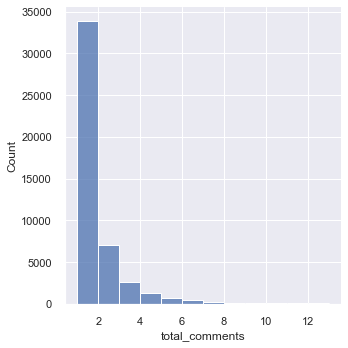

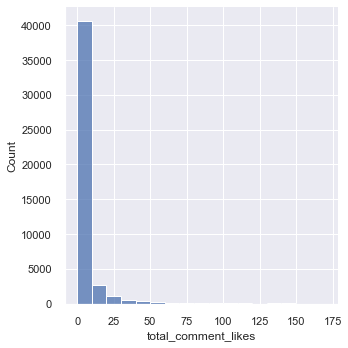

In [343]:
distribute_plot(viewer_data, 'total_comments', 1, 1)
distribute_plot(viewer_data, 'total_comment_likes', 1, 10)

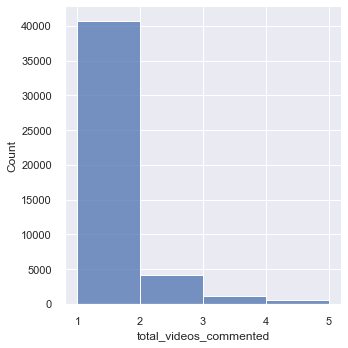

In [355]:
#['total_comments', 'total_videos_commented', 'average_comments_per_video', 'total_comment_likes',
#'average_likes_per_comment', 'total_comments_as_reply', 'reply_ratio', 'avg_comment_days_after_publish']

distribute_plot(viewer_data, 'total_videos_commented', 1, 1)

In [354]:
max(viewer_data[viewer_data['total_videos_commented'] < 40]['total_videos_commented'])

23

### Subscribed channels

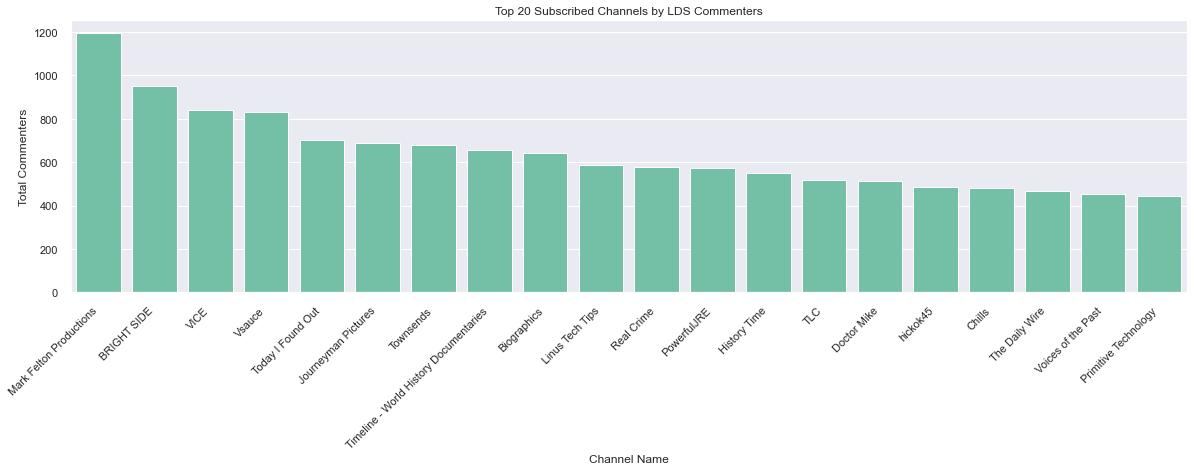

In [323]:
# Most subscribed channels by LDS commenters
subbed_channels = pd.DataFrame(viewer_subscription_df['sub_channel_name'].value_counts()[:20].reset_index())

fig, ax = plt.subplots()

sns.barplot(data=subbed_channels,x='index',y='sub_channel_name',color='#66CDAA')
plt.xticks(rotation=10)

labels = ax.get_xticklabels()
fig.set_figwidth(20)
fig.set_figheight(5)
plt.setp(labels, rotation=45, horizontalalignment = 'right')
plt.title('Top 20 Subscribed Channels by LDS Commenters')
plt.xlabel('Channel Name')
plt.ylabel('Total Commenters')
plt.show();

### Video tags

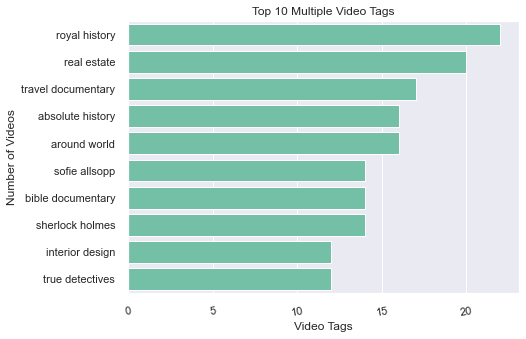

In [432]:
one_tag_freq = pd.DataFrame(multiple_tags['top_tags'].value_counts()[:10].reset_index())

fig, ax = plt.subplots()
sns.barplot(data=one_tag_freq,x='top_tags',y='index',color='#66CDAA')
plt.xticks(rotation=10)

labels = ax.get_xticklabels()
fig.set_figwidth(7)
fig.set_figheight(5)
plt.title('Top 10 Multiple Video Tags')
plt.xlabel('Video Tags')
plt.ylabel('Number of Videos')
plt.show();

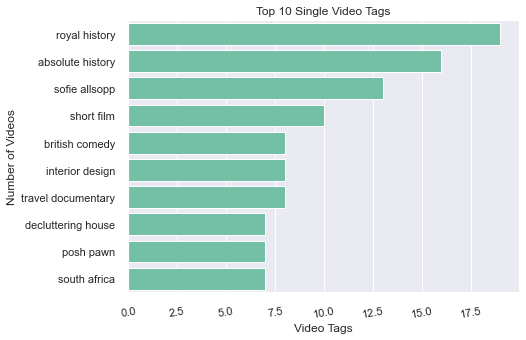

In [433]:
one_tag_freq = pd.DataFrame(one_tag['top_tags'].value_counts()[:10].reset_index())

fig, ax = plt.subplots()
sns.barplot(data=one_tag_freq,x='top_tags',y='index',color='#66CDAA')
plt.xticks(rotation=10)

labels = ax.get_xticklabels()
fig.set_figwidth(7)
fig.set_figheight(5)
plt.title('Top 10 Single Video Tags')
plt.xlabel('Video Tags')
plt.ylabel('Number of Videos')
plt.show();

In [292]:
one_tag.to_csv('hah.csv')

## Feature Selection
By checking correlation matrix, further filtering on columns can be done

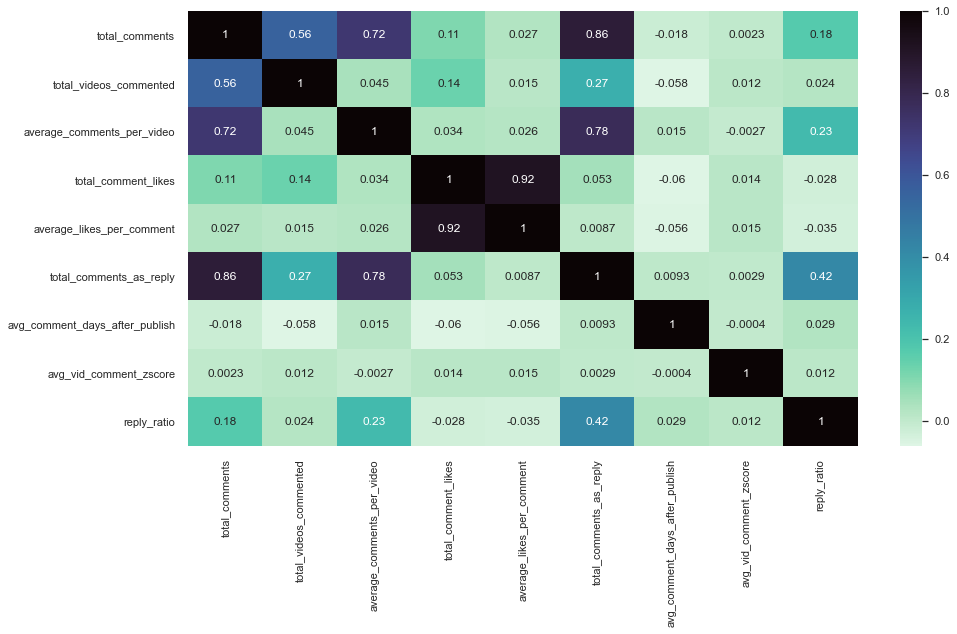

In [19]:
numerical_columns = ['total_comments', 'total_videos_commented', 'average_comments_per_video', 'total_comment_likes',
                   'average_likes_per_comment', 'total_comments_as_reply', 'avg_comment_days_after_publish',
                   'avg_vid_comment_zscore', 'reply_ratio']
category_columns = []
for i in video_df.columns:
    if i.startswith('vid_cat_'):
        category_columns.append(i)

sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(viewer_data[numerical_columns].corr(), annot=True, cmap='mako_r')

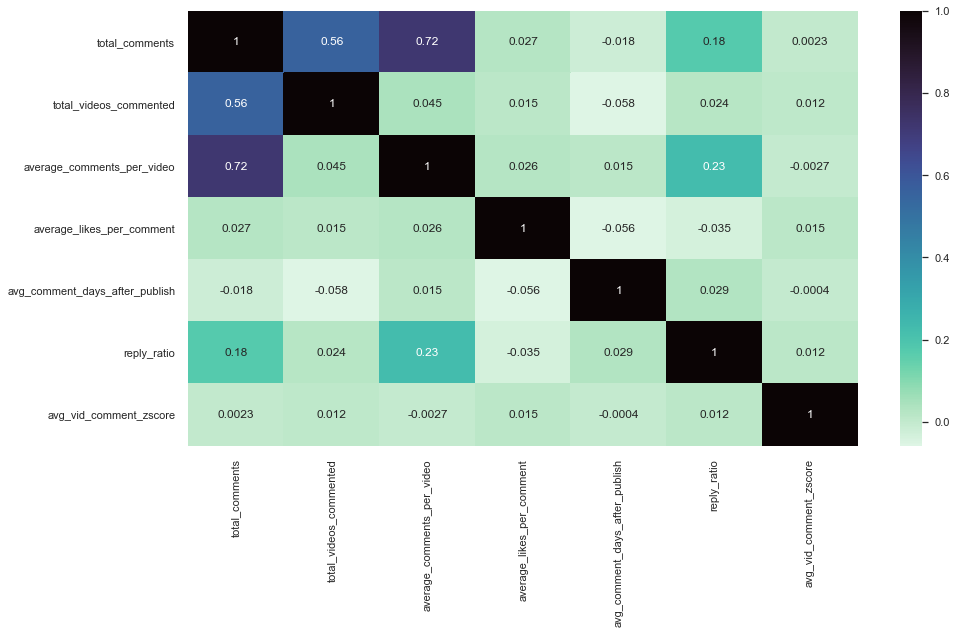

In [20]:
final_features = ['total_comments', 'total_videos_commented', 'average_comments_per_video',
                   'average_likes_per_comment', 'avg_comment_days_after_publish', 'reply_ratio',
                   'avg_vid_comment_zscore']
ax = sns.heatmap(viewer_data[final_features].corr(), annot=True, cmap='mako_r')

## Category PCA Representation

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

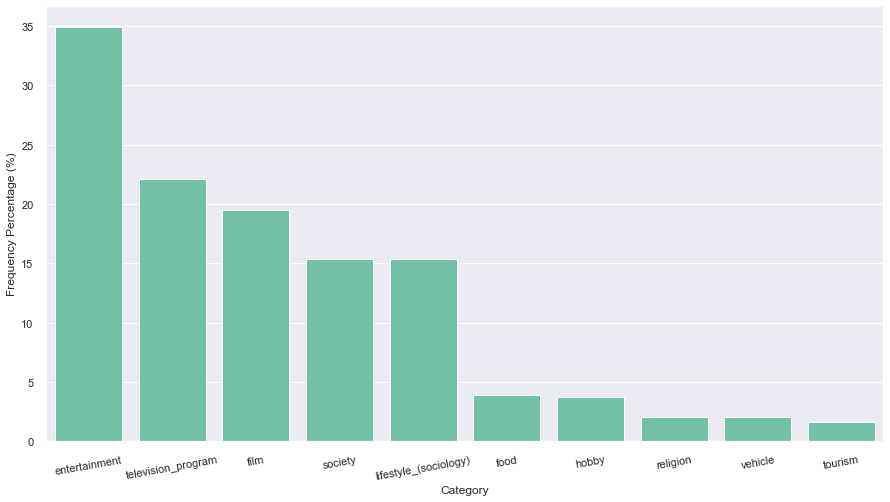

In [322]:
category_frequency = pd.DataFrame(video_df[category_columns].sum().sort_values(ascending=False)[:10] * 100 / len(video_df)).reset_index()
category_frequency['index'] = [i.replace('vid_cat_', '') for i in category_frequency['index']]

sns.barplot(data=category_frequency,x='index',y=0,color='#66CDAA')
plt.xlabel('Category')
plt.ylabel('Frequency Percentage (%)')
plt.xticks(rotation=10)

transformed shape: (44198, 7)


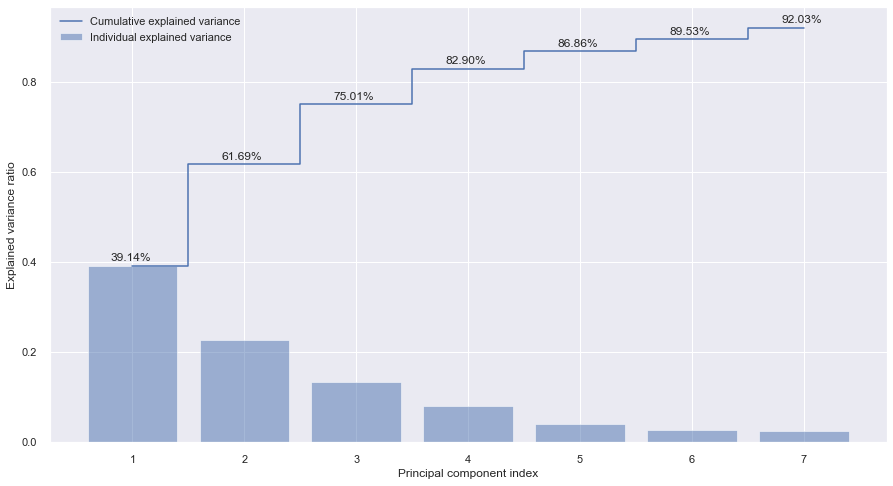

In [25]:
categories_df = cleaned_viewer_data[category_columns].copy()

#Change to binary variable
for i in categories_df:
    categories_df[i] = np.where((categories_df[i] > 0), 1, 0)

pca = decomposition.PCA(n_components=7)
categories_pca = pd.DataFrame(pca.fit_transform(categories_df))
print("transformed shape:", categories_pca.shape)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')

for i in range(1,len(cum_sum_eigenvalues)+1):
    plt.text(i-0.2, cum_sum_eigenvalues[i-1]+0.01, '{:.2f}%'.format(cum_sum_eigenvalues[i-1]*100))
    
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')

plt.legend(loc='best')
plt.show()

## Outlier Removal and Standardization

In [24]:
#replace na to zero in zscore column
viewer_data = viewer_data.fillna(0)

#find absolute value of z-score for each observation
z = np.abs(stats.zscore(viewer_data[final_features]))

#only keep rows in dataframe with all z-scores less than absolute value of 3 
cleaned_viewer_data = viewer_data[final_features + category_columns][(z<3).all(axis=1)]
print(len(viewer_data))
print(len(cleaned_viewer_data))

46859
44198


In [26]:
scaler = StandardScaler()
#-Fit the scaler using available training data.
scaled_viewer_df = pd.DataFrame(scaler.fit_transform(cleaned_viewer_data[final_features]), columns=final_features)

# #Apply the scale to Validation data.
scaled_viewer_df = pd.concat([scaled_viewer_df, categories_pca],axis=1,join='inner')

## Filtering Subscription Data
Further filtering will be done to subscription data to remove channels that only have less than 10 subscribers from the dataset. This is done to hasten the data mining process while still maintain enough information

In [29]:
#Get subscribed channels with less than 10 subscribers
subs_count = viewer_subscription_df['sub_channel_link'].value_counts()
chan_morethan20 = subs_count[subs_count >= 20]

#Remove channels from viewer subscription dataset
index_names = viewer_subscription_df[~viewer_subscription_df['sub_channel_link'].isin(chan_morethan20.index)].index
viewer_subscription_df.drop(index_names, inplace = True)
viewer_subscription_df

viewer_link           sub_channel_name  \
3       UCE5rPlC0N1Hwv2MlkFvDH0A        Uncle Tony's Garage   
7       UCE5rPlC0N1Hwv2MlkFvDH0A              Curious World   
18      UCE5rPlC0N1Hwv2MlkFvDH0A                   MrBallen   
27      UCE5rPlC0N1Hwv2MlkFvDH0A  JCS - Criminal Psychology   
28      UCE5rPlC0N1Hwv2MlkFvDH0A               That Chapter   
...                          ...                        ...   
466116  UCavTTC85uQEMO8Tod1fEwBg                  Thoughty2   
466118  UCavTTC85uQEMO8Tod1fEwBg                  Be. Busta   
466119  UCavTTC85uQEMO8Tod1fEwBg                 Latte ASMR   
466121  UCavTTC85uQEMO8Tod1fEwBg              Wolters World   
466122  UCavTTC85uQEMO8Tod1fEwBg                      WIRED   

                sub_channel_link         sub_channel_pub_date  
3       UC9SzQNYLqsPQGY_nbHogDDw  2019-09-03T06:07:53.114763Z  
7       UCkylPk1D5uKAsMa60aW5miQ  2021-06-20T23:46:13.986915Z  
18      UCtPrkXdtCM5DACLufB9jbsA  2021-01-24T09:31:33.508181Z  
27      UCYwVxWpjeKFWwu8TML-Te9A  2019-12-05T10:28:17.347768Z  
28      UCL44k-cLrlsdr7PYuMU4yIw  2019-06-24T05:46:14.740795Z  
...                          ...                          ...  
466116  UCRlICXvO4XR4HMeEB9JjDlA  2020-07-22T18:13:39.116667Z  
466118  UC-ir6MfYIuyvVJS_DhOhcJw         2017-02-21T05:18:40Z  
466119  UCQe2Y7V-C9bNMAcCJCBvzQQ  2018-03-29T15:52:26.713361Z  
466121  UCFr3sz2t3bDp6Cux08B93KQ  2020-06-12T21:39:07.453907Z  
466122  UCftwRNsjfRo08xYE31tkiyw  2018-10-04T14:06:41.277003Z  

[148947 rows x 4 columns]

In [30]:
print("Total subscribed channels: ", viewer_subscription_df['sub_channel_link'].nunique())
print("Total viewers: ", viewer_subscription_df['viewer_link'].nunique())

Total subscribed channels:  2500
Total viewers:  9745


# Clustering

In [745]:
#Dataframe to save the clustering result using different methods
clustering_result = pd.DataFrame(columns=['clustering', 'method', 'score'])

In [746]:
def record_result(result, clustering_name, X, labels):
    '''
    Record clustering result into input dataframe
    '''
    result = result.append({
        'clustering': clustering_name,
        'method': 'db',
        'score': sklearn.metrics.davies_bouldin_score(X, labels)
    }, ignore_index=True)

    result = result.append({
        'clustering': clustering_name,
        'method': 'ch',
        'score': sklearn.metrics.calinski_harabasz_score(X, labels)
    }, ignore_index=True)

    result = result.append({
        'clustering': clustering_name,
        'method': 's',
        'score': sklearn.metrics.silhouette_score(X, labels)
    }, ignore_index=True)
    
    X_transformed = X.to_numpy()
    result = result.append({
        'clustering': clustering_name,
        'method': 's_dbw',
        'score': S_Dbw(X_transformed, labels, method='Tong', alg_noise='bind', centr='mean', nearest_centr=True, metric='euclidean')
    }, ignore_index=True)
    
    return result

## Visualising Data Points
Using PCA, reduce dataset into 2D so it can be visualised using scatter plot - visual inspection

transformed shape: (44198, 2)


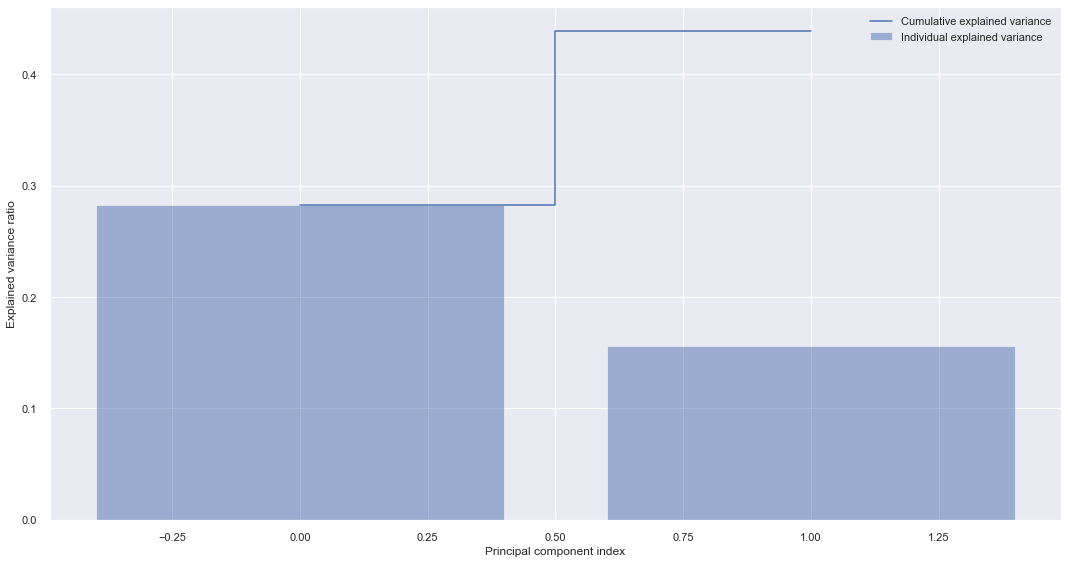

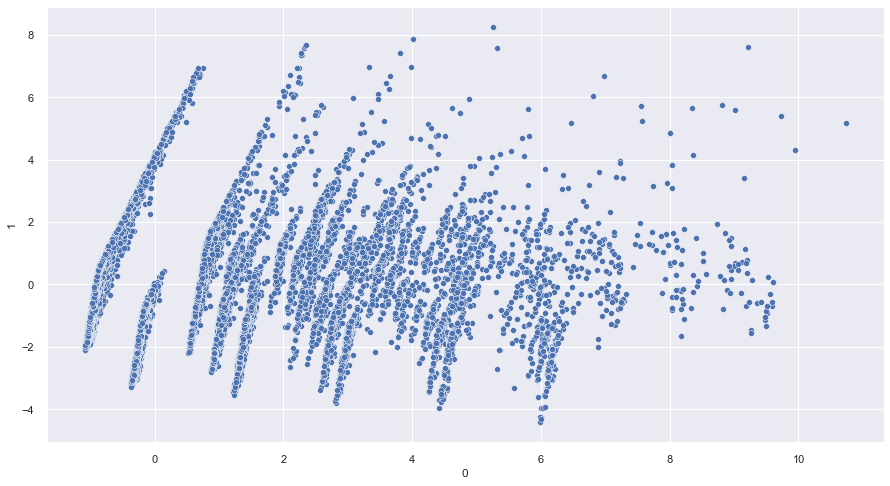

In [31]:
# Conduct PCA to visually inspect any clustering in viewer dataset
pca = decomposition.PCA(n_components=2)
pca_region_df_train = pd.DataFrame(pca.fit_transform(scaled_viewer_df))
print("transformed shape:", pca_region_df_train.shape)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

sns.scatterplot(x=0, y=1, data=pca_region_df_train)

## K-Means
Firstly, using elbow method and silhouette coefficient, determine optimal K

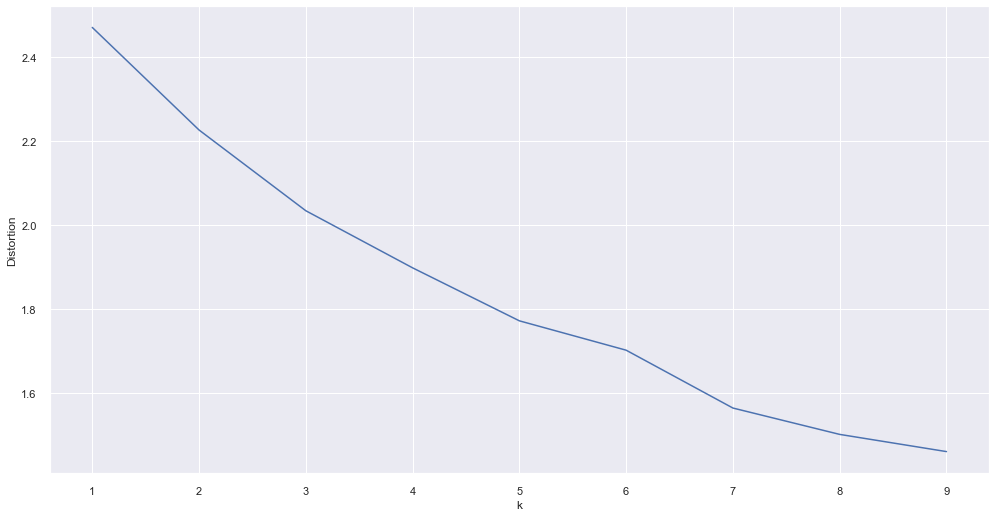

In [748]:
# Calculate distance for each K to determine optimal number of cluster
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(scaled_viewer_df)
    kmeanModel.fit(scaled_viewer_df)
    distortions.append(sum(np.min(cdist(scaled_viewer_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / scaled_viewer_df.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

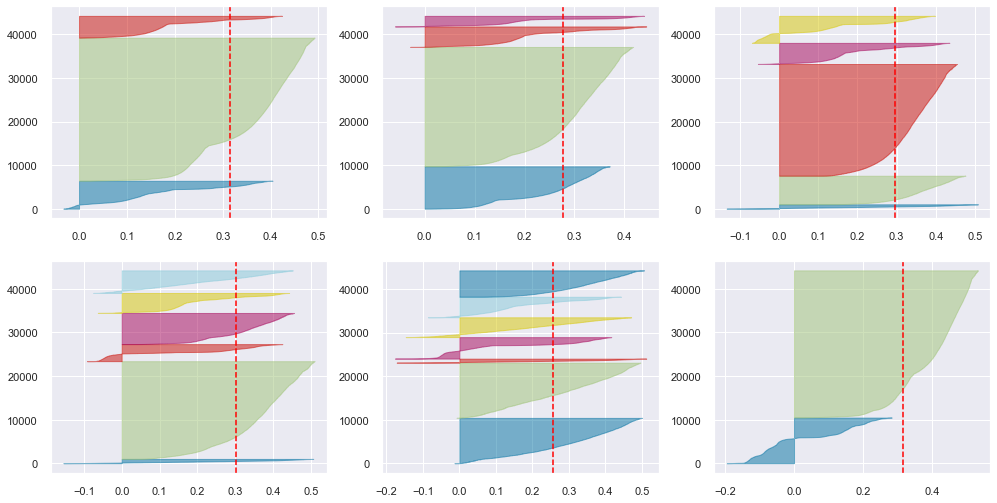

In [749]:
fig, ax = plt.subplots(2, 3, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 3)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(scaled_viewer_df)

1    27374
0    11709
2     5115
Name: cluster, dtype: int64


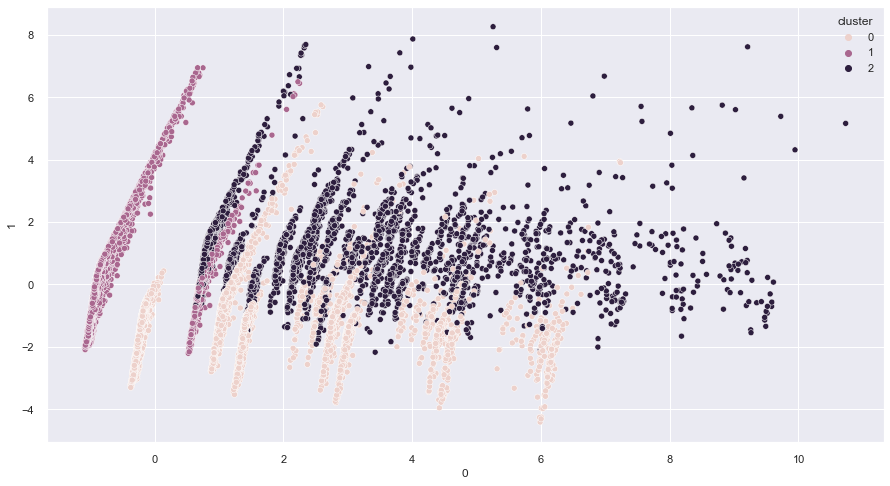

In [32]:
#k-means using 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_viewer_df)

cluster_3means= kmeans.predict(scaled_viewer_df)

pca_region_df_train['cluster'] = cluster_3means
print(pca_region_df_train['cluster'].value_counts())
sns.scatterplot(x=0, y=1, data=pca_region_df_train, hue='cluster')

In [751]:
clustering_result = record_result(clustering_result, '3 k-means', scaled_viewer_df, cluster_3means)

1    24501
3     9446
0     5675
2     4576
Name: cluster, dtype: int64


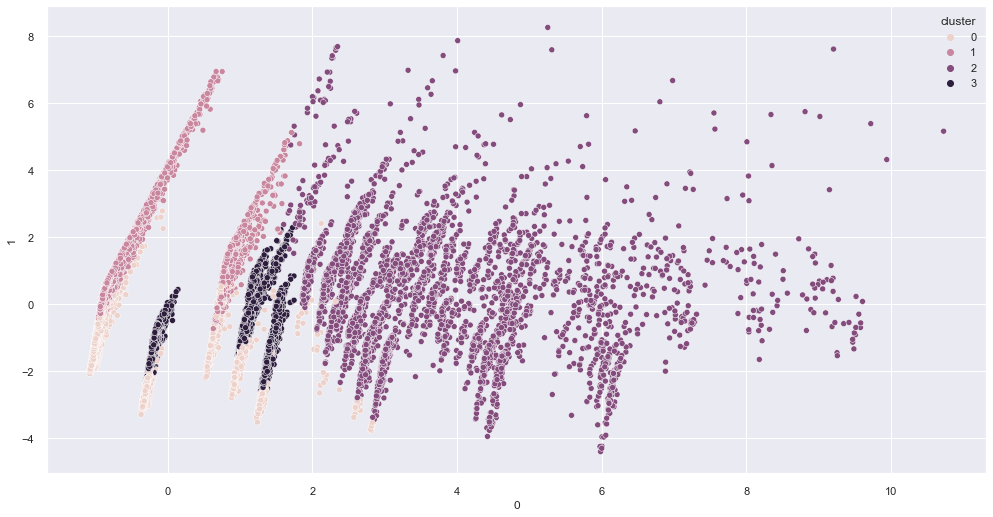

In [752]:
#k-means using abritary number to check clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(scaled_viewer_df)

cluster_4means = kmeans.predict(scaled_viewer_df)

pca_region_df_train['cluster'] = cluster_4means
print(pca_region_df_train['cluster'].value_counts())
sns.scatterplot(x=0, y=1, data=pca_region_df_train, hue='cluster')

In [753]:
clustering_result = record_result(clustering_result, '4 k-means', scaled_viewer_df, cluster_4means)

## DBSCAN
Firstly, calculate distance between points and the neighbours to estimate optimal epsilon

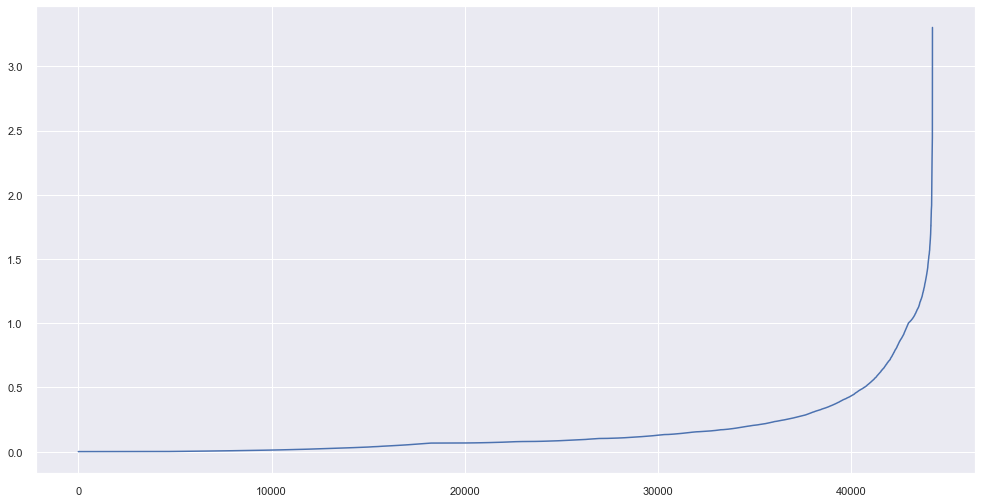

In [754]:
neigh = NearestNeighbors(n_neighbors=400)
nbrs = neigh.fit(scaled_viewer_df)
distances, indices = nbrs.kneighbors(scaled_viewer_df)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances);

-1    23886
 0    10310
 2     6532
 1     1879
 3     1591
Name: 0, dtype: int64


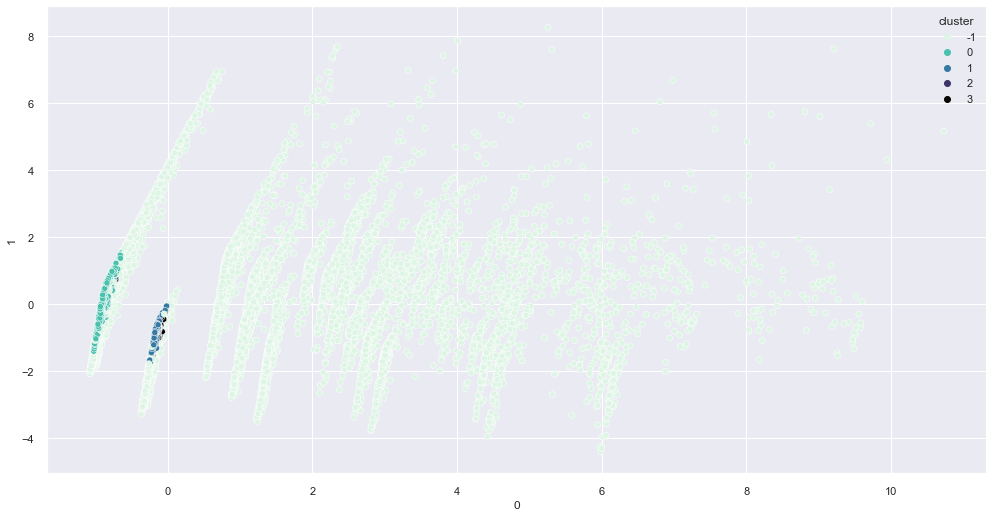

In [755]:
db_default = DBSCAN(eps = 0.8, min_samples = 400).fit(scaled_viewer_df)
db08labels = db_default.labels_

print(pd.DataFrame(db08labels)[0].value_counts())
pca_region_df_train['cluster'] = db08labels
sns.scatterplot(x=pca_region_df_train[0], y=pca_region_df_train[1], hue =pca_region_df_train['cluster'], palette='mako_r')

In [756]:
clustering_result = record_result(clustering_result, '0.8 DBSCAN', scaled_viewer_df, db08labels)

 0    20717
-1    17866
 1     4489
 2      612
 3      514
Name: 0, dtype: int64


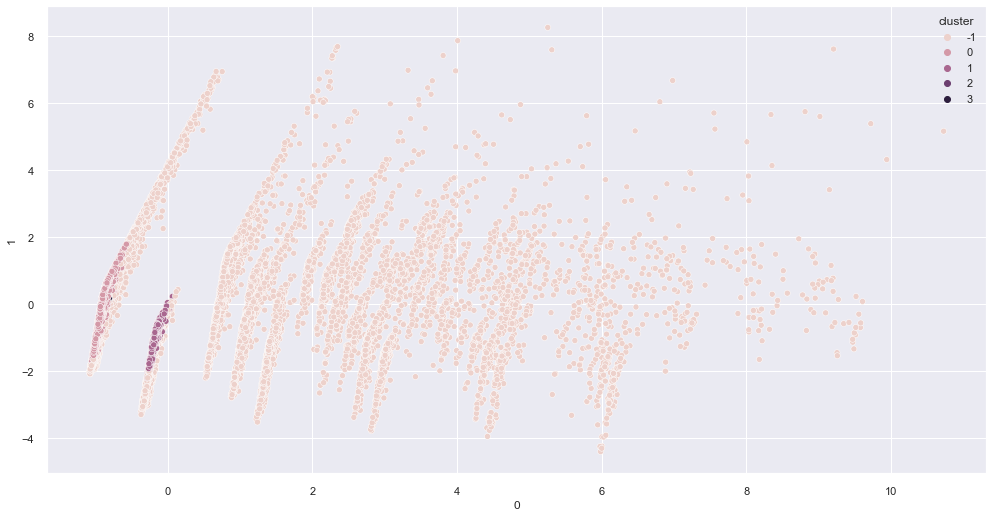

In [757]:
db_default = DBSCAN(eps = 1, min_samples = 400).fit(scaled_viewer_df)
db1labels = db_default.labels_

print(pd.DataFrame(db1labels)[0].value_counts())
pca_region_df_train['cluster'] = db1labels
sns.scatterplot(x=pca_region_df_train[0], y=pca_region_df_train[1], hue=pca_region_df_train['cluster'] )

In [758]:
clustering_result = record_result(clustering_result, '1.0 DBSCAN', scaled_viewer_df, db1labels)

 0    25248
-1     9550
 1     5770
 2     1352
 4      940
 3      743
 5      595
Name: 0, dtype: int64


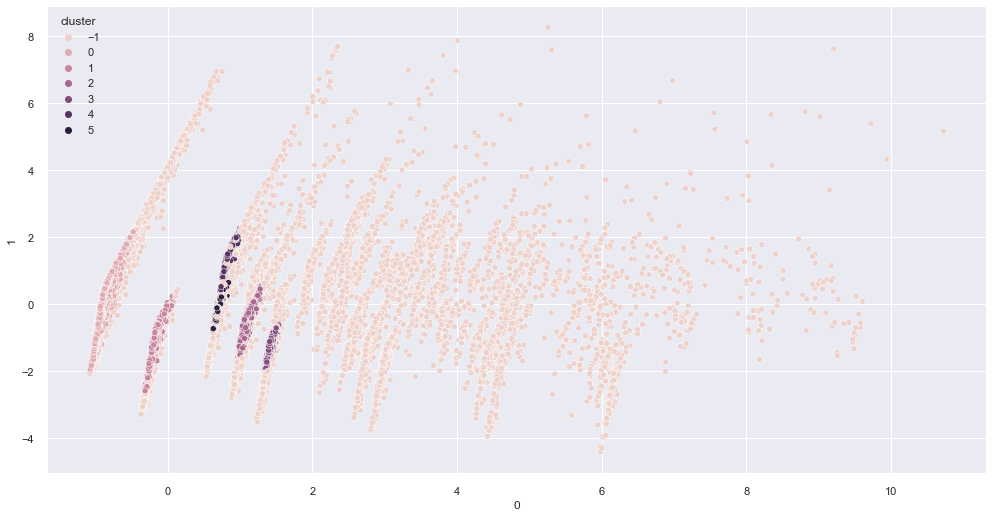

In [759]:
db_default = DBSCAN(eps = 1.2, min_samples = 400).fit(scaled_viewer_df)
db12labels = db_default.labels_

print(pd.DataFrame(db12labels)[0].value_counts())
pca_region_df_train['cluster'] = db12labels
sns.scatterplot(x=pca_region_df_train[0], y=pca_region_df_train[1], hue=pca_region_df_train['cluster'] )

In [760]:
clustering_result = record_result(clustering_result, '1.2 DBSCAN', scaled_viewer_df, db12labels)

 0    25718
 2     6495
-1     5195
 3     3759
 1     2218
 4      813
Name: 0, dtype: int64


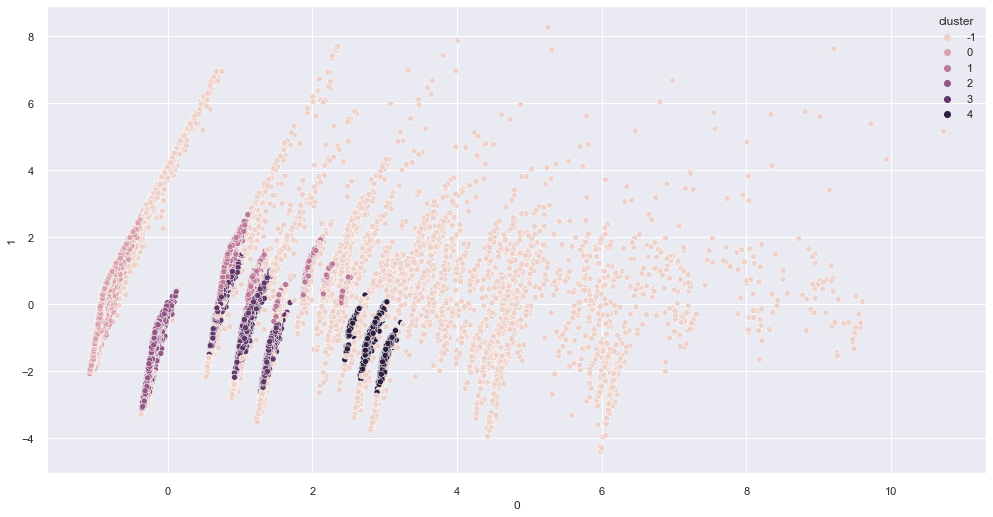

In [761]:
db_default = DBSCAN(eps = 1.5, min_samples = 400).fit(scaled_viewer_df)
db15labels = db_default.labels_

print(pd.DataFrame(db15labels)[0].value_counts())
pca_region_df_train['cluster'] = db15labels
sns.scatterplot(x=pca_region_df_train[0], y=pca_region_df_train[1], hue=pca_region_df_train['cluster'] )

In [762]:
clustering_result = record_result(clustering_result, '1.5 DBSCAN', scaled_viewer_df, db15labels)

## Hierarchical Agglomerative Clustering

HAC for 3 clusters for different linkage method

2    43315
1      842
0       41
Name: Clusta3, dtype: int64


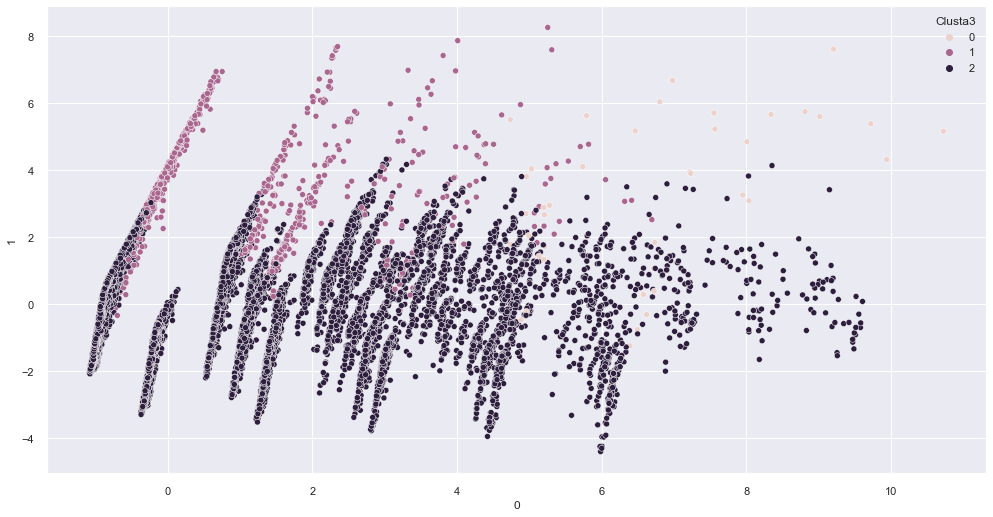

In [763]:
modela3 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')
clusta3 = modela3.fit(scaled_viewer_df)
pca_region_df_train['Clusta3']=clusta3.labels_

print(pca_region_df_train['Clusta3'].value_counts())
sns.scatterplot(x=pca_region_df_train[0], y=pca_region_df_train[1], hue=pca_region_df_train['Clusta3'] )

1    25955
0    13278
2     4965
Name: Clustw3, dtype: int64


C:\Users\gparu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


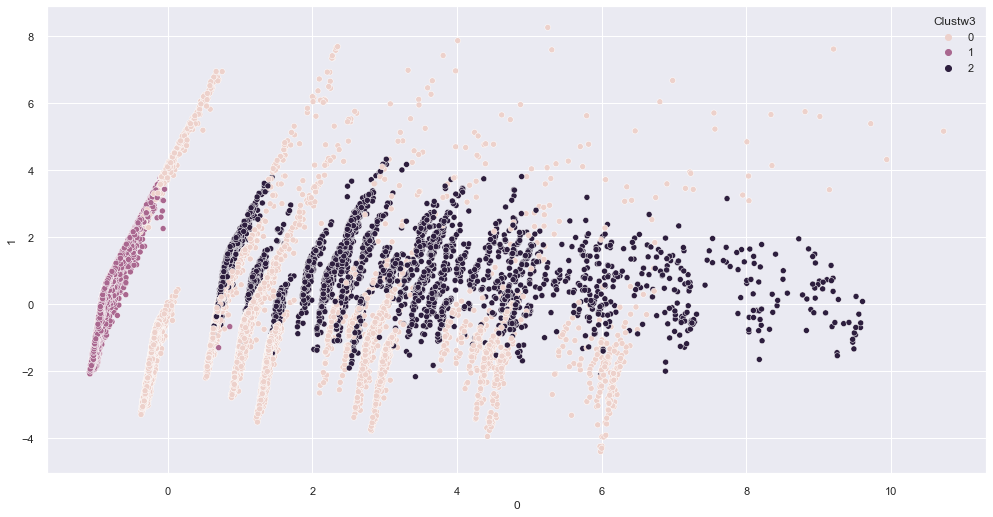

In [764]:
modelw3 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clustw3 = modelw3.fit(scaled_viewer_df)
pca_region_df_train['Clustw3']=clustw3.labels_

print(pca_region_df_train['Clustw3'].value_counts())
sns.scatterplot(pca_region_df_train[0], pca_region_df_train[1], hue=pca_region_df_train['Clustw3'] )

In [765]:
clustering_result = record_result(clustering_result, '3 Ward HAC', scaled_viewer_df, clustw3.labels_)

0    44196
2        1
1        1
Name: Clusts3, dtype: int64


C:\Users\gparu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


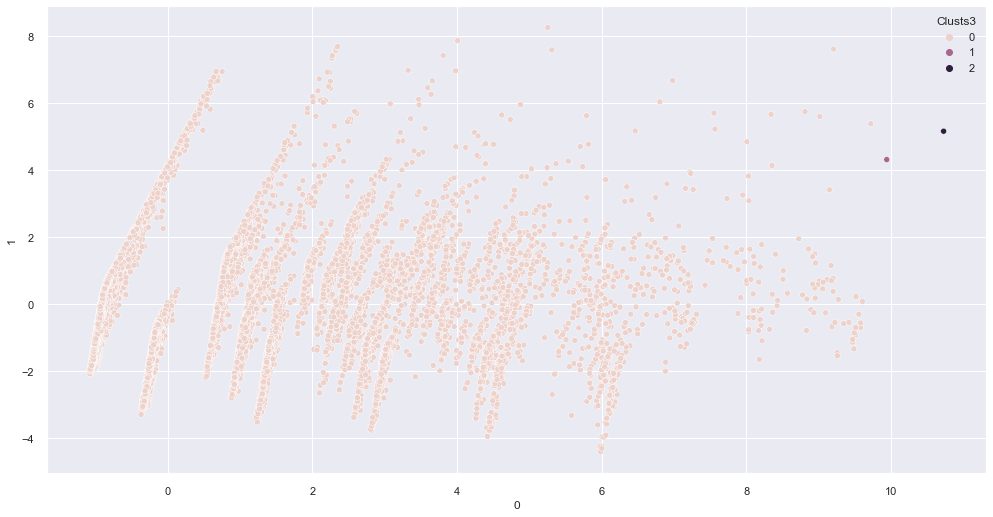

In [766]:
models3 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='single')
clusts3 = models3.fit(scaled_viewer_df)
pca_region_df_train['Clusts3']=clusts3.labels_

print(pca_region_df_train['Clusts3'].value_counts())
sns.scatterplot(pca_region_df_train[0], pca_region_df_train[1], hue=pca_region_df_train['Clusts3'] )

0    43462
2      676
1       60
Name: Clustc3, dtype: int64


C:\Users\gparu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


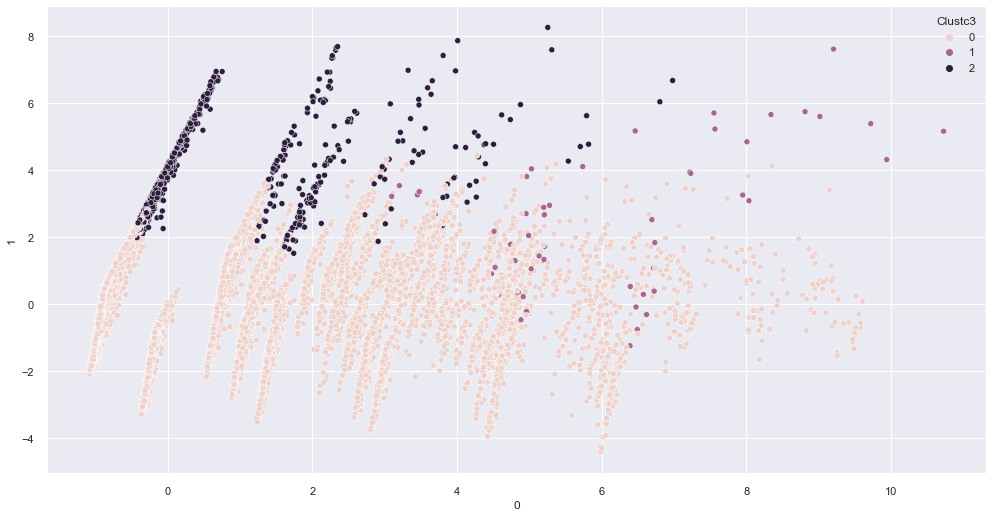

In [767]:
modelc3 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
clustc3 = modelc3.fit(scaled_viewer_df)
pca_region_df_train['Clustc3']=clustc3.labels_

print(pca_region_df_train['Clustc3'].value_counts())
sns.scatterplot(pca_region_df_train[0], pca_region_df_train[1], hue=pca_region_df_train['Clustc3'] )

2    43315
0      842
1       24
3       17
Name: Clusta4, dtype: int64


C:\Users\gparu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


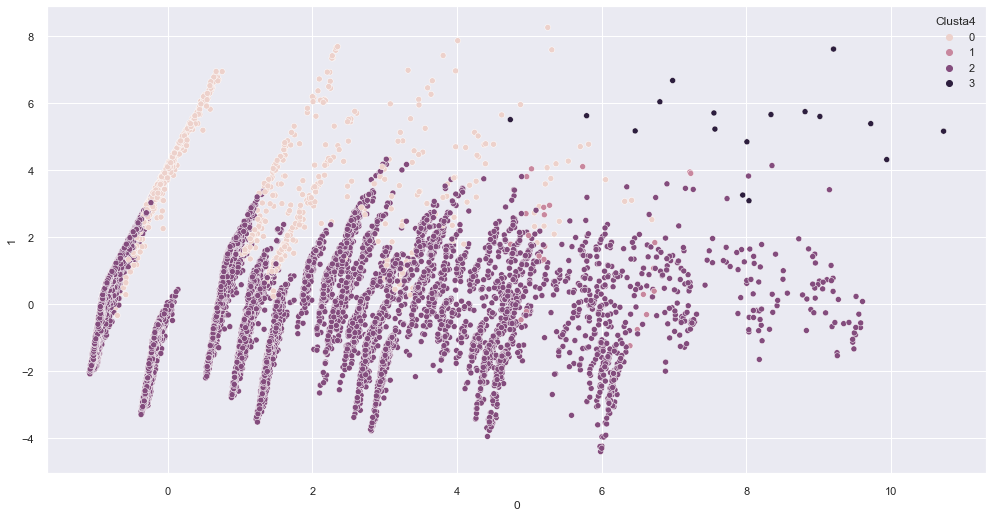

In [768]:
modela4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')
clusta4 = modela4.fit(scaled_viewer_df)
pca_region_df_train['Clusta4']=clusta4.labels_

print(pca_region_df_train['Clusta4'].value_counts())
sns.scatterplot(pca_region_df_train[0], pca_region_df_train[1], hue=pca_region_df_train['Clusta4'] )

1    25955
0     6730
3     6548
2     4965
Name: Clustw4, dtype: int64


C:\Users\gparu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


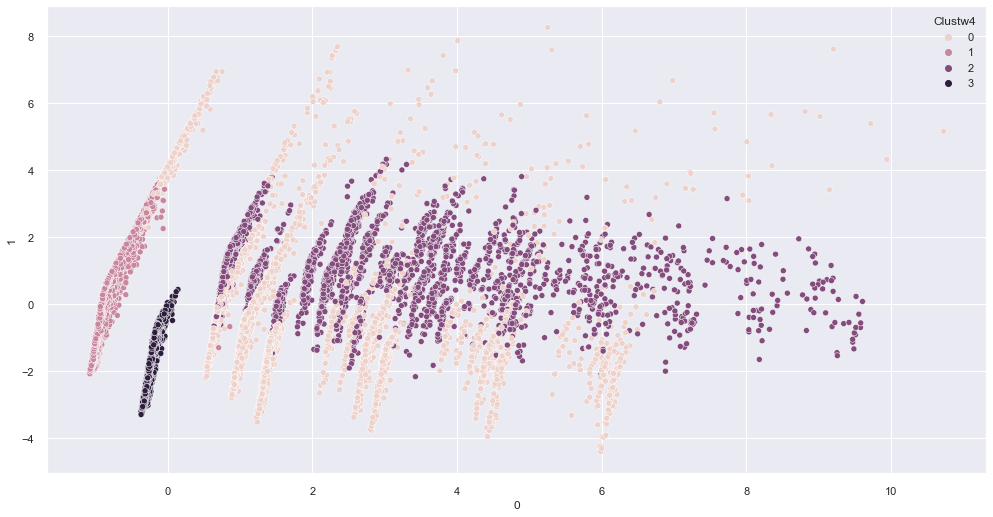

In [769]:
modelw4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
clustw4 = modelw4.fit(scaled_viewer_df)
pca_region_df_train['Clustw4']=clustw4.labels_

print(pca_region_df_train['Clustw4'].value_counts())
sns.scatterplot(pca_region_df_train[0], pca_region_df_train[1], hue=pca_region_df_train['Clustw4'] )

In [770]:
clustering_result = record_result(clustering_result, '4 Ward HAC', scaled_viewer_df, clustw4.labels_)

0    44195
3        1
2        1
1        1
Name: Clusts4, dtype: int64


C:\Users\gparu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


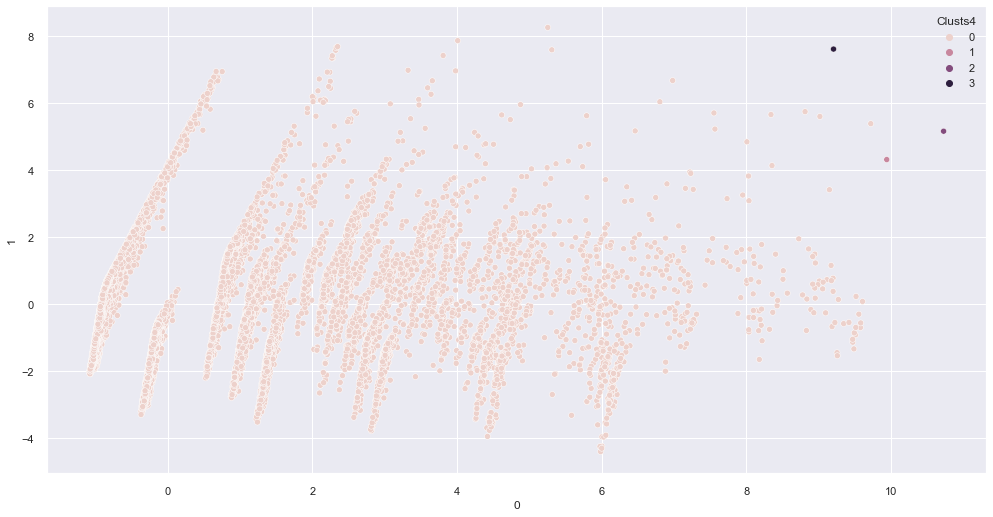

In [771]:
models4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='single')
clusts4 = models4.fit(scaled_viewer_df)
pca_region_df_train['Clusts4']=clusts4.labels_

print(pca_region_df_train['Clusts4'].value_counts())
sns.scatterplot(pca_region_df_train[0], pca_region_df_train[1], hue=pca_region_df_train['Clusts4'] )

3    42130
1     1332
2      676
0       60
Name: Clustc4, dtype: int64


C:\Users\gparu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


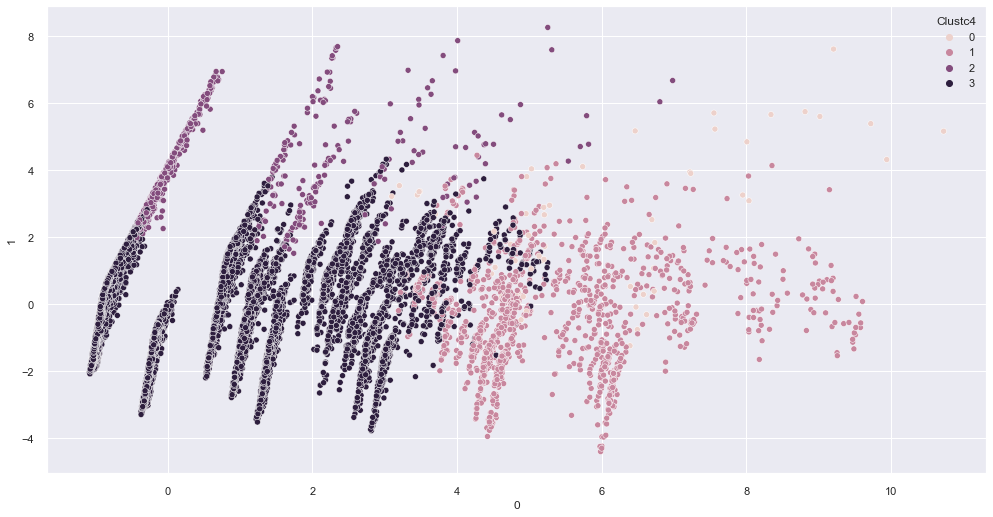

In [772]:
modelc4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
clustc4 = modelc4.fit(scaled_viewer_df)
pca_region_df_train['Clustc4']=clustc4.labels_

print(pca_region_df_train['Clustc4'].value_counts())
sns.scatterplot(pca_region_df_train[0], pca_region_df_train[1], hue=pca_region_df_train['Clustc4'] )

In [773]:
clustering_result

clustering method        score
0    3 k-means     db     1.582180
1    3 k-means     ch  9958.554705
2    3 k-means      s     0.286072
3    3 k-means  s_dbw     0.956489
4    4 k-means     db     1.477932
5    4 k-means     ch  9017.937684
6    4 k-means      s     0.246195
7    4 k-means  s_dbw     0.894103
8   0.8 DBSCAN     db     2.188560
9   0.8 DBSCAN     ch  1838.587986
10  0.8 DBSCAN      s    -0.056834
11  0.8 DBSCAN  s_dbw     0.935714
12  1.0 DBSCAN     db     1.893054
13  1.0 DBSCAN     ch  2659.590909
14  1.0 DBSCAN      s     0.000971
15  1.0 DBSCAN  s_dbw     0.905536
16  1.2 DBSCAN     db     2.098144
17  1.2 DBSCAN     ch  3168.500391
18  1.2 DBSCAN      s     0.093384
19  1.2 DBSCAN  s_dbw     0.826210
20  1.5 DBSCAN     db     1.881325
21  1.5 DBSCAN     ch  5267.506546
22  1.5 DBSCAN      s     0.237700
23  1.5 DBSCAN  s_dbw     0.805934
24  3 Ward HAC     db     1.707208
25  3 Ward HAC     ch  9372.404480
26  3 Ward HAC      s     0.280327
27  3 Ward HAC  s_dbw     0.944954
28  4 Ward HAC     db     1.457475
29  4 Ward HAC     ch  9369.267784
30  4 Ward HAC      s     0.271432
31  4 Ward HAC  s_dbw     0.877382

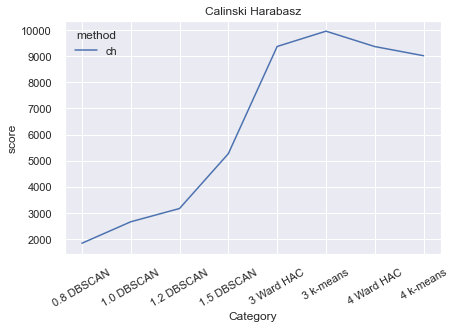

In [796]:
ch = clustering_result[clustering_result['method'] == 'ch'].copy().sort_values('clustering')
plt.figure(figsize=(6,4))
plt.xticks(rotation=30)
plt.xlabel('Category')
plt.title('Calinski Harabasz')
sns.lineplot(x='clustering', y='score', data=ch, hue='method')

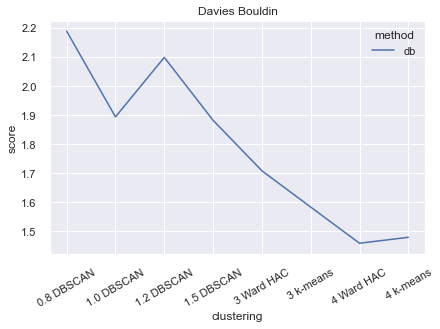

In [797]:
both = clustering_result[clustering_result['method'] == 'db'].copy().sort_values('clustering')
plt.figure(figsize=(6,4))
plt.xticks(rotation=30)
plt.title('Davies Bouldin')
sns.lineplot(x='clustering', y='score', data=both, hue='method')

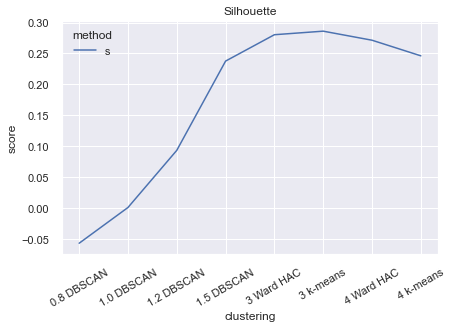

In [798]:
ch = clustering_result[clustering_result['method'] == 's'].copy().sort_values('clustering')
plt.figure(figsize=(6,4))
plt.xticks(rotation=30)
plt.title('Silhouette')
sns.lineplot(x='clustering', y='score', data=ch, hue='method')

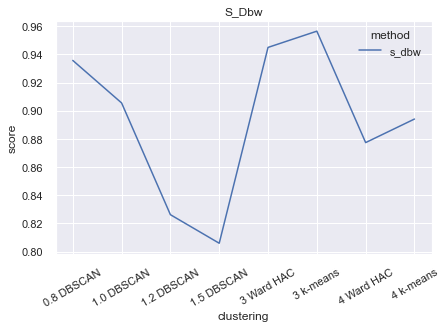

In [799]:
ch = clustering_result[clustering_result['method'] == 's_dbw'].copy().sort_values('clustering')
plt.figure(figsize=(6,4))
plt.xticks(rotation=30)
plt.title('S_Dbw')
sns.lineplot(x='clustering', y='score', data=ch, hue='method')

## Cluster Result Exploration

In [35]:
clustered_viewer_data = cleaned_viewer_data.copy()
clustered_viewer_data['cluster'] = cluster_3means
desc = clustered_viewer_data.groupby('cluster').describe().copy()

In [155]:
len(comment_df)

78904

In [154]:
comment_df[comment_df['author_id'].isin(high_value['author_id'])]

video_id                                            comment  \
2      Js-QLGTFO9Y  "This is not the fashion industry", oh but it ...   
7      Js-QLGTFO9Y  These British people should have more compassi...   
18     Js-QLGTFO9Y  Does Richard not realize that putting rubbish ...   
20     Js-QLGTFO9Y          Quite sure I've seen this epsiode before.   
21     Js-QLGTFO9Y                              They should pick zerg   
...            ...                                                ...   
78897  vQgDdKviA8Q  Bettany Hughes has changed, but she is still a...   
78899  vQgDdKviA8Q  @Peter Roberts: Feck off! If I want to think a...   
78900  vQgDdKviA8Q  She’s a older woman now,a mother and wife,and ...   
78901  vQgDdKviA8Q  She’s  a  married woman with kids now,but back...   
78902  vQgDdKviA8Q  @FTW1207: An ideal woman; beauty, brains, and ...   

            author_name             timestamp  likes  reply_flag  \
2      Brendan Geraghty  2021-06-23T12:38:59Z      4           0   
7       Karen Bochinski  2021-06-23T05:37:40Z      0           0   
18           Nikotastik  2021-06-22T23:36:30Z     16           0   
20       Pagona Barbata  2021-06-22T22:53:08Z      0           0   
21            Jolfer 13  2021-06-22T22:53:03Z      0           0   
...                 ...                   ...    ...         ...   
78897           FTW1207  2021-02-23T18:13:27Z     20           0   
78899    NobleKorhedron  2021-03-08T19:44:05Z      0           1   
78900     Peter Roberts  2021-03-08T15:44:58Z      1           1   
78901     Peter Roberts  2021-03-07T11:29:45Z      2           1   
78902    NobleKorhedron  2021-03-07T03:48:57Z      0           1   

                      author_id  comment_polarity  comment_subjectivity  
2      UCE5rPlC0N1Hwv2MlkFvDH0A           -0.2263              0.752381  
7      UCDD_DrE32wOtSAXSqUCA_KQ            0.2460              0.250000  
18     UCKA5b9-x1EE8BbCaYfHMyKw           -0.4215              0.188889  
20     UC1dD9ewMIOPdOqasm5NLg-g            0.3804              0.888889  
21     UCIFJOa7NYKzbxCsH-7ISoeQ            0.0000              0.000000  
...                         ...               ...                   ...  
78897  UCyvHwWmmTHQUePXkMdijMGA            0.7351              0.000000  
78899  UCHxxztigc9AMda1U6ZXepTw           -0.4184              0.100000  
78900  UCN8EIzrWJVcxmTFvElWZsvg            0.0000              0.333333  
78901  UCN8EIzrWJVcxmTFvElWZsvg           -0.3182              0.239646  
78902  UCHxxztigc9AMda1U6ZXepTw            0.8020              1.000000  

[15455 rows x 9 columns]

In [333]:
cleaned_viewer_data = viewer_data[final_features + category_columns + ['total_comment_likes']][(z<3).all(axis=1)]
clustered_viewer_data = cleaned_viewer_data.copy()
clustered_viewer_data['cluster'] = cluster_3means

cluster_sum = clustered_viewer_data[final_features+['total_comment_likes', 'cluster']].groupby('cluster').sum().copy()
cluster_sum

total_comments  total_videos_commented  average_comments_per_video  \
cluster                                                                       
0                 19701                   11709                19701.000000   
1                 28480                   27374                28480.000000   
2                 15455                   11298                 6995.833333   

         average_likes_per_comment  avg_comment_days_after_publish  \
cluster                                                              
0                          44870.0                   153455.450000   
1                         116096.0                   348301.500000   
2                          34756.0                    54893.153175   

          reply_ratio  avg_vid_comment_zscore  total_comment_likes  
cluster                                                             
0        10048.916667              132.441629                44870  
1            0.000000             -448.644771               116096  
2         1425.307540              122.090198                78554

In [329]:
cluster_mean = clustered_viewer_data[final_features+['cluster']].groupby('cluster').mean().copy()
cluster_mean

total_comments  total_videos_commented  average_comments_per_video  \
cluster                                                                       
0              1.682552                1.000000                    1.682552   
1              1.040403                1.000000                    1.040403   
2              3.021505                2.208798                    1.367709   

         average_likes_per_comment  avg_comment_days_after_publish  \
cluster                                                              
0                         3.832095                       13.105769   
1                         4.241105                       12.723807   
2                         6.794917                       10.731799   

         reply_ratio  avg_vid_comment_zscore  
cluster                                       
0           0.858222                0.011311  
1           0.000000               -0.016389  
2           0.278653                0.023869

In [42]:
clustered_viewer_data['cluster'].value_counts(normalize=True)

1    0.619349
0    0.264921
2    0.115729
Name: cluster, dtype: float64

In [37]:
desc[['total_comments', 'total_videos_commented']]

total_comments                                               \
                 count      mean       std  min  25%  50%  75%  max   
cluster                                                               
0              11709.0  1.682552  0.941537  1.0  1.0  1.0  2.0  5.0   
1              27374.0  1.040403  0.196907  1.0  1.0  1.0  1.0  2.0   
2               5115.0  3.021505  1.426304  2.0  2.0  3.0  3.0  9.0   

        total_videos_commented                                              
                         count      mean      std  min  25%  50%  75%  max  
cluster                                                                     
0                      11709.0  1.000000  0.00000  1.0  1.0  1.0  1.0  1.0  
1                      27374.0  1.000000  0.00000  1.0  1.0  1.0  1.0  1.0  
2                       5115.0  2.208798  0.40697  1.0  2.0  2.0  2.0  3.0

In [144]:
desc[['average_comments_per_video']]

average_comments_per_video                                          \
                             count      mean       std  min  25%  50%  75%   
cluster                                                                      
0                          11709.0  1.682552  0.941537  1.0  1.0  1.0  2.0   
1                          27374.0  1.040403  0.196907  1.0  1.0  1.0  1.0   
2                           5115.0  1.367709  0.606689  1.0  1.0  1.0  1.5   

              
         max  
cluster       
0        5.0  
1        2.0  
2        4.5

In [40]:
desc[['avg_comment_days_after_publish', 'average_likes_per_comment']]

avg_comment_days_after_publish                                       \
                                 count       mean        std  min  25%  50%   
cluster                                                                       
0                              11709.0  13.105769  15.493773  0.0  2.0  7.0   
1                              27374.0  12.723807  15.355886  0.0  1.0  7.0   
2                               5115.0  10.731799  12.291772  0.0  2.0  6.0   

                     average_likes_per_comment                                 \
          75%    max                     count      mean        std  min  25%   
cluster                                                                         
0        19.0  70.25                   11709.0  3.832095  10.623860  0.0  0.0   
1        18.0  70.00                   27374.0  4.241105  12.831195  0.0  0.0   
2        15.0  70.00                    5115.0  6.794917  16.225251  0.0  0.5   

                          
         50%  75%    max  
cluster                   
0        1.0  3.0  147.0  
1        1.0  2.0  149.0  
2        2.0  5.5  149.0

In [41]:
desc[['reply_ratio', 'avg_vid_comment_zscore']]

reply_ratio                                                    \
              count      mean       std  min       25%  50%  75%  max   
cluster                                                                 
0           11709.0  0.858222  0.241500  0.0  0.666667  1.0  1.0  1.0   
1           27374.0  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.0   
2            5115.0  0.278653  0.334969  0.0  0.000000  0.0  0.5  1.0   

        avg_vid_comment_zscore                                          \
                         count      mean       std       min       25%   
cluster                                                                  
0                      11709.0  0.011311  0.829282 -2.716243 -0.493984   
1                      27374.0 -0.016389  1.000780 -2.750976 -0.738580   
2                       5115.0  0.023869  0.681474 -2.551473 -0.405042   

                                       
              50%       75%       max  
cluster                                
0       -0.028692  0.586414  2.417452  
1       -0.056383  0.814589  2.485377  
2        0.012488  0.484482  2.012634

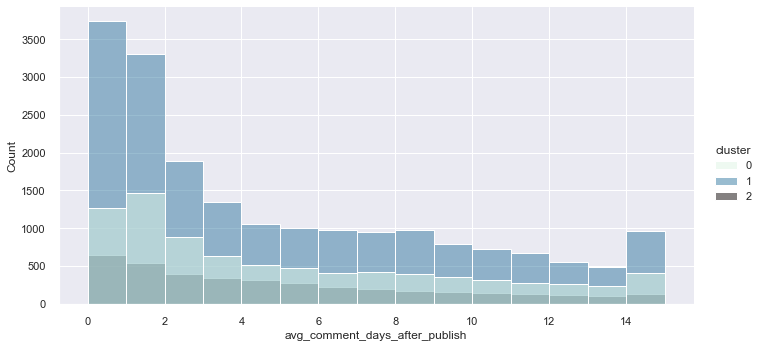

In [182]:
high_value = clustered_viewer_data[clustered_viewer_data['cluster']==2].copy()
interactive = clustered_viewer_data[clustered_viewer_data['cluster']==0].copy()
casual = clustered_viewer_data[clustered_viewer_data['cluster']==1].copy()
responsiveness = clustered_viewer_data[clustered_viewer_data['avg_comment_days_after_publish'] <= 15]

sns.displot(x='avg_comment_days_after_publish', data=responsiveness, binwidth=1, hue='cluster', height=5, aspect=2, palette='mako_r')

In [50]:
high_value[high_value['avg_comment_days_after_publish'] < 15]['average_likes_per_comment'].mean()

7.778140506659687

In [57]:
comment_under_15_days = combined_vid_com_df[combined_vid_com_df['comment_days_after_publish'] <= 15].copy()
comment_under_15_days['total_likes']

In [183]:
high_value=high_value.merge(viewer_data[['author_id']], left_index=True, right_index=True)
interactive = interactive.merge(viewer_data[['author_id']], left_index=True, right_index=True)
casual = casual.merge(viewer_data[['author_id']], left_index=True, right_index=True)

In [233]:
#DataFrame to show which video a viewer commented on
high_subscription = pd.DataFrame(high_value['author_id'].unique())

#Combine video and subscription dataframe with viewer as the connection
high_subscription=pd.merge(high_subscription, viewer_subscription_df, left_on=0,
                   right_on= ['viewer_link'], 
                   how = 'left').dropna()

#DataFrame to show which video a viewer commented on
interactive_subscription = pd.DataFrame(interactive['author_id'].unique())

#Combine video and subscription dataframe with viewer as the connection
interactive_subscription=pd.merge(interactive_subscription, viewer_subscription_df, left_on=0,
                   right_on= ['viewer_link'], 
                   how = 'left').dropna()

#DataFrame to show which video a viewer commented on
casual_subscription = pd.DataFrame(casual['author_id'].unique())

#Combine video and subscription dataframe with viewer as the connection
casual_subscription=pd.merge(casual_subscription, viewer_subscription_df, left_on=0,
                   right_on= ['viewer_link'], 
                   how = 'left').dropna()

In [125]:
high_subscription['viewer_link'].nunique()

1095

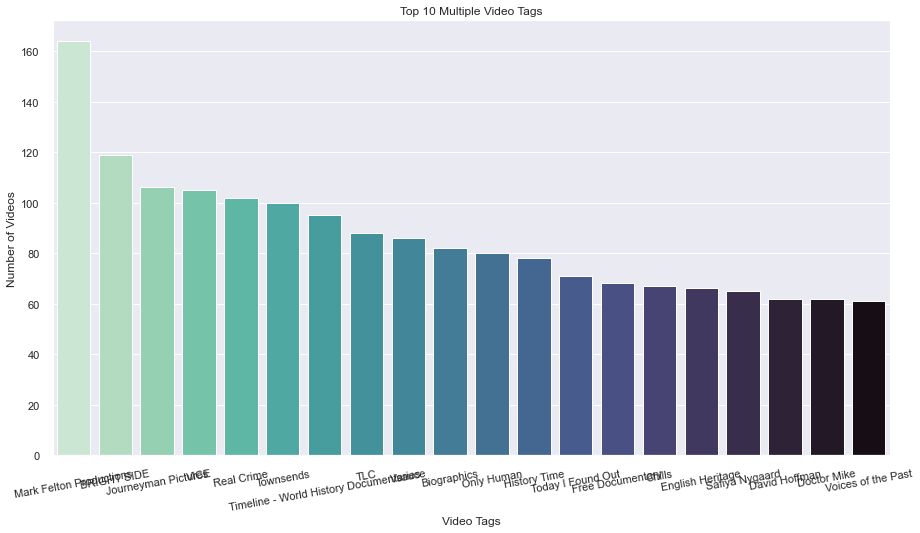

In [96]:
high_subscription_count = pd.DataFrame(high_subscription['sub_channel_name'].value_counts().reset_index()[:20])

sns.barplot(data=high_subscription_count,x='index',y='sub_channel_name',palette='mako_r')
plt.xticks(rotation=10)

labels = ax.get_xticklabels()
fig.set_figwidth(7)
fig.set_figheight(5)
plt.title('Top 10 Multiple Video Tags')
plt.xlabel('Video Tags')
plt.ylabel('Number of Videos')
plt.show();

In [421]:
high_subscription_count = pd.DataFrame(high_subscription['sub_channel_name'].value_counts().reset_index())
casual_subscription_count = pd.DataFrame(casual_subscription['sub_channel_name'].value_counts().reset_index())
interactive_subscription_count = pd.DataFrame(interactive_subscription['sub_channel_name'].value_counts().reset_index())
subbed_channels = pd.DataFrame(viewer_subscription_df['sub_channel_name'].value_counts().reset_index())

abc = pd.merge(high_subscription_count,subbed_channels,how='left', on='index')
abc['per'] = abc['sub_channel_name_x'] / abc['sub_channel_name_y']
abc.sort_values('per', ascending=False, inplace=True)
xxx=abc[abc['per']>0.21]['sub_channel_name_x'].sum()
yyy=abc[abc['per']>0.21]['sub_channel_name_y'].sum()
xxx/yyy

0.2486278814489572

In [232]:
interactive_subscription_count

index  sub_channel_name
0               Mark Felton Productions               315
1                                Vsauce               227
2                           BRIGHT SIDE               225
3                                  VICE               214
4                     Today I Found Out               201
...                                 ...               ...
2518  Highway to Heaven - Full Episodes                 1
2519             Nature Healing Society                 1
2520                         Vice Ganda                 1
2521                     Rebecca Zamolo                 1
2522                        Unsellables                 1

[2523 rows x 2 columns]

In [137]:
subbed_channels['per'] = subbed_channels['sub_channel_name'] / viewer_subscription_df['viewer_link'].nunique()

In [422]:
high_subscription_count['high_percentage'] = high_subscription_count['sub_channel_name'] / high_subscription['viewer_link'].nunique()
casual_subscription_count['casual_percentage'] = casual_subscription_count['sub_channel_name'] / casual_subscription['viewer_link'].nunique()
interactive_subscription_count['interactive_percentage'] = interactive_subscription_count['sub_channel_name'] / interactive_subscription['viewer_link'].nunique()
subbed_channels['total_percentage'] = subbed_channels['sub_channel_name'] / video_subscription['viewer_link'].nunique()
casual_subscription_count

index  sub_channel_name  casual_percentage
0     Mark Felton Productions               664           0.118149
1                 BRIGHT SIDE               557           0.099110
2                        VICE               484           0.086121
3                      Vsauce               474           0.084342
4           Today I Found Out               393           0.069929
...                       ...               ...                ...
2521            Sarah Therèse                 3           0.000534
2522          Lindsay Holiday                 2           0.000356
2523      House Historia YTTV                 1           0.000178
2524     Odins Men (OdinsMen)                 1           0.000178
2525         Eric “A” Pettway                 1           0.000178

[2526 rows x 3 columns]

In [423]:
merged_df = (subbed_channels.merge(high_subscription_count, how='left', on='index').merge(casual_subscription_count, how='left', on='index').merge(interactive_subscription_count, how='left', on='index'))
merged_df = merged_df[:5].copy()

In [424]:
merged_df = merged_df[['index', 'total_percentage', 'high_percentage', 'casual_percentage', 'interactive_percentage']].copy()
merged_df = merged_df.melt(['index'], var_name='cluster')
merged_df['value'] = merged_df['value'] * 100

In [425]:
merged_df

index                 cluster      value
0   Mark Felton Productions        total_percentage  12.257468
1               BRIGHT SIDE        total_percentage   9.783390
2                      VICE        total_percentage   8.623345
3                    Vsauce        total_percentage   8.551483
4         Today I Found Out        total_percentage   7.186121
5   Mark Felton Productions         high_percentage  14.977169
6               BRIGHT SIDE         high_percentage  10.867580
7                      VICE         high_percentage   9.589041
8                    Vsauce         high_percentage   7.853881
9         Today I Found Out         high_percentage   6.484018
10  Mark Felton Productions       casual_percentage  11.814947
11              BRIGHT SIDE       casual_percentage   9.911032
12                     VICE       casual_percentage   8.612100
13                   Vsauce       casual_percentage   8.434164
14        Today I Found Out       casual_percentage   6.992883
15  Mark Felton Productions  interactive_percentage  12.524851
16              BRIGHT SIDE  interactive_percentage   8.946322
17                     VICE  interactive_percentage   8.508946
18                   Vsauce  interactive_percentage   9.025845
19        Today I Found Out  interactive_percentage   7.992048

ValueError: Could not interpret input 'total_percentage'

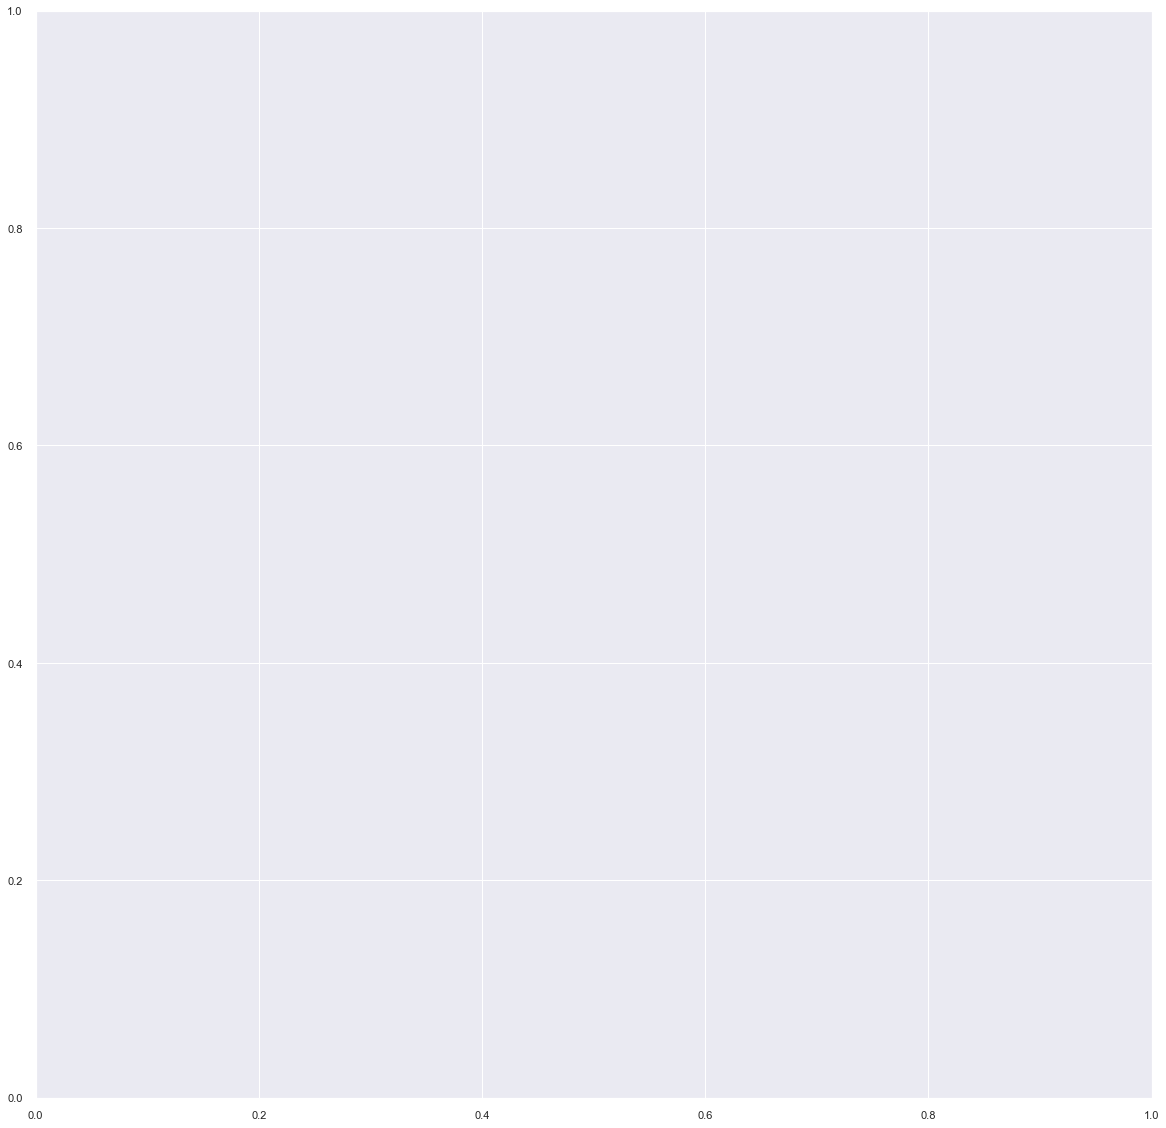

In [409]:
fig_dims = (20,20)
fig, ax = plt.subplots(figsize=fig_dims)
s1 = sns.barplot(x = 'index', y = 'total_percentage', data = merged_df, color = 'red')
s2 = sns.barplot(x = 'index', y = 'high_percentage', data = merged_df, color = 'lightblue')
s3 = sns.barplot(x = 'index', y = 'casual_percentage', data = merged_df, color = 'lightgreen')
s4 = sns.barplot(x = 'index', y = 'interactive_percentage', data = merged_df, color = 'lightpink')

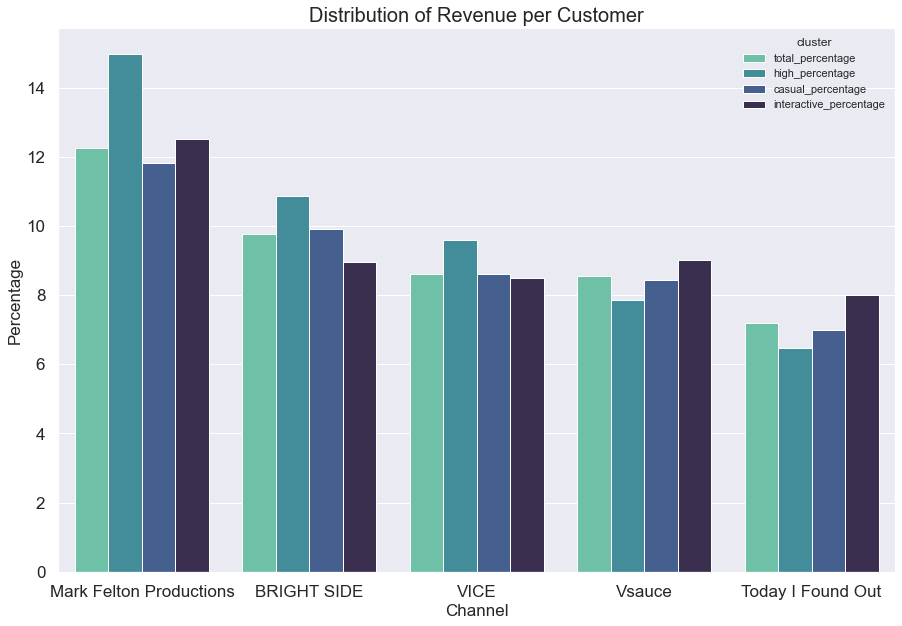

In [427]:
# scattter plot of price and carat observations relaionship
# stating the size of the plot
fig_dims = (15,10)
fig, ax = plt.subplots(figsize=fig_dims)

# generating the scatterplot
a = sns.barplot(data=merged_df, x="index",y='value',hue="cluster", palette='mako_r')

# setting up its labels
a.axes.set_title("Distribution of Revenue per Customer",fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
a.set_ylabel("Percentage",fontsize=17)
a.set_xlabel("Channel",fontsize=17);

In [130]:
subbed_channels[:20]['sub_channel_name']/viewer_subscription_df['viewer_link'].nunique()

0     0.122524
1     0.097794
2     0.086198
3     0.085480
4     0.071832
5     0.070703
6     0.069882
7     0.067419
8     0.066085
9     0.060236
10    0.059415
11    0.059005
12    0.056234
13    0.053053
14    0.052540
15    0.049666
16    0.049461
17    0.048025
18    0.046280
19    0.045664
Name: sub_channel_name, dtype: float64

In [117]:
abc[abc['per']>0.21].count()

index                 205
sub_channel_name_x    205
sub_channel_name_y    205
per                   205
dtype: int64

In [118]:
abc.count()

index                 2445
sub_channel_name_x    2445
sub_channel_name_y    2445
per                   2445
dtype: int64

In [191]:
subbed_channels

index  sub_channel_name
0             Mark Felton Productions              1194
1                         BRIGHT SIDE               953
2                                VICE               840
3                              Vsauce               833
4                   Today I Found Out               700
...                               ...               ...
2525              House Historia YTTV                 1
2526                 Eric “A” Pettway                 1
2527                Guilty of Treeson                 1
2528  Gold Shaw Farm (Gold Shaw Farm)                 1
2529                    trustylimbs🗺️                 1

[2530 rows x 2 columns]

In [68]:
high_value

total_comments  total_videos_commented  average_comments_per_video  \
2                   3                       2                         1.5   
7                   2                       2                         1.0   
17                  2                       2                         1.0   
19                  3                       3                         1.0   
20                  3                       3                         1.0   
...               ...                     ...                         ...   
46532               4                       2                         2.0   
46540               6                       2                         3.0   
46547               2                       2                         1.0   
46640               4                       2                         2.0   
46794               2                       2                         1.0   

       average_likes_per_comment  avg_comment_days_after_publish  reply_ratio  \
2                      14.000000                        1.666667     0.333333   
7                       4.000000                        3.000000     0.500000   
17                      8.000000                        1.500000     0.000000   
19                      3.666667                        0.000000     0.000000   
20                      1.666667                        1.666667     0.000000   
...                          ...                             ...          ...   
46532                   0.500000                       69.000000     0.750000   
46540                   5.000000                       20.500000     0.666667   
46547                   0.000000                       26.000000     0.000000   
46640                  10.000000                        3.500000     0.500000   
46794                  13.500000                        0.000000     0.000000   

       avg_vid_comment_zscore  vid_cat_television_program  vid_cat_society  \
2                    0.060000                         0.0              2.0   
7                    0.274215                         0.0              1.0   
17                   0.138066                         0.0              0.0   
19                   0.572919                         0.0              0.0   
20                  -0.282207                         1.0              0.0   
...                       ...                         ...              ...   
46532               -0.459562                         0.0              0.0   
46540                0.535157                         0.0              0.0   
46547               -0.035568                         0.0              0.0   
46640                1.227174                         0.0              0.0   
46794               -0.028095                         0.0              0.0   

       vid_cat_entertainment  ...  vid_cat_politics  vid_cat_basketball  \
2                        0.0  ...               0.0                 0.0   
7                        0.0  ...               0.0                 0.0   
17                       0.0  ...               0.0                 0.0   
19                       1.0  ...               0.0                 0.0   
20                       2.0  ...               0.0                 0.0   
...                      ...  ...               ...                 ...   
46532                    0.0  ...               0.0                 0.0   
46540                    0.0  ...               0.0                 0.0   
46547                    0.0  ...               0.0                 0.0   
46640                    0.0  ...               0.0                 0.0   
46794                    0.0  ...               0.0                 0.0   

       vid_cat_mixed_martial_arts  vid_cat_fashion  vid_cat_rock_music  \
2                             0.0              0.0                 0.0   
7                             0.0              0.0                 0.0   
17                            0.0              0.

# Association Rules Mining

In [160]:
#DataFrame to show which video a viewer commented on
viewer_video = pd.DataFrame(comment_df.groupby(['video_id', 'author_id']).size().reset_index(name='Freq'))

#Combine video and subscription dataframe with viewer as the connection
video_subscription=pd.merge(viewer_video, viewer_subscription_df, left_on=  ['author_id'],
                   right_on= ['viewer_link'], 
                   how = 'left').dropna()

In [303]:
def encode_transform(data):
    '''
    Turn data into columns and assign 1 or 0
    '''
    encoder = TransactionEncoder()
    encoded_data = encoder.fit(data).transform(data)
    encoded_data_df = pd.DataFrame(encoded_data,columns=encoder.columns_)
    encoded_data_df = encoded_data_df.replace(False,0)
    return encoded_data_df

In [162]:
#
viewer_subscription_df = viewer_subscription_df.dropna()
viewer_subs_row = viewer_subscription_df[['viewer_link', 'sub_channel_name']].groupby(['viewer_link'])['sub_channel_name'].apply(';;;'.join).reset_index()
viewer_subs_row['sub_channel_name'] = [i.split(";;;") for i in viewer_subs_row['sub_channel_name']]
viewer_subs_row

viewer_link  \
0     UC--Az-GyV4yaNLCALdUUyGg   
1     UC--DkOzfvmvWjhvUZJ5wcUg   
2     UC--PYDDnTu2mu7Ae68E0nPg   
3     UC--cKL3UN-ns5J1a9wGWp0A   
4     UC-0RZePJJtqxWy4TmHFrOUA   
...                        ...   
9740  UCzyC3ACoBig9qiCYfSGbVPQ   
9741  UCzyGBoT_GvV0u3Cm8dOTW1A   
9742  UCzyNBfvTBujhNCwMj9JHFgA   
9743  UCzzLREhqukxLVbrcpeqpXnw   
9744  UCzzvQFT3TXlaonQb8djv9FQ   

                                       sub_channel_name  
0     [WhatCulture Horror, Baumgartner Restoration, ...  
1     [Grjngo - Western Movies, On The Tools, steveo...  
2     [Ice Cream Rolls, Chills, NileRed, KraftsbyKat...  
3     [George Ezra, eSysman SuperYachts, TEDx Talks,...  
4     [Nahre Sol, guitaro5000, Matt Steffanina, The ...  
...                                                 ...  
9740  [Allison Pregler, Fowler's Makery and Mischief...  
9741  [Philosophy Tube, Chills, Jacob Geller, Unknow...  
9742  [The Kick Off, HITC Sport, VinAnd Sori, Trevsc...  
9743  [Adult Swim, TheCrafsMan SteadyCraftin, Space ...  
9744  [Eros Now Music, ATHLEAN-X™, Davie504, Thought...  

[9745 rows x 2 columns]

## ARM - One tag
Each video will only have one tag. For each row, there will only be 1 tag and 1 subscribed channel.

In [359]:
video_onetag_subscription=pd.merge(video_subscription, one_tag, left_on=  ['video_id'],
                   right_on= ['link'], 
                   how = 'left').dropna()


pd.DataFrame(video_onetag_subscription).to_csv('ARM/video_onetag_subscription.csv')

# Generate a list of each analysis row
onetags_channel = []
for i,j in video_onetag_subscription.iterrows():
    onetags_channel.append([j['sub_channel_name'], j['top_tags']])

#onetags_channel_df = encode_transform(onetags_channel)

In [363]:
video_onetag_subscription[['sub_channel_name', 'top_tags']]

sub_channel_name      top_tags
0          TheJapanChannelDcom  new dominion
1       myworldisgettingdumber  new dominion
2          Journeyman Pictures  new dominion
3                        Break  new dominion
4                thejuicemedia  new dominion
...                        ...           ...
184513          Martha Stewart  lake muskoka
184514                   Abode  lake muskoka
184515              Bob & Brad  lake muskoka
184516           British Pathé  lake muskoka
184517              Veritasium  lake muskoka

[184518 rows x 2 columns]

In [ ]:
#onetags_channel_apriori = apriori(onetags_channel_df, min_support = 0.005, use_colnames = True)
#onetags_channel_result = association_rules(onetags_channel_apriori, metric = "confidence", min_threshold=0.1)
#onetags_channel_result.sort_values('lift')

#onetags_channel_result = pd.read_csv('onetags_channel_result.csv')

## ARM - Multiple tags
Each video will have multiple tags. For each row, there will only be 1 tag and 1 subscribed channel.

In [360]:
video_multtags_subscription=pd.merge(video_subscription, multiple_tags, left_on=  ['video_id'],
                   right_on= ['link'], 
                   how = 'left').dropna()

pd.DataFrame(video_onetag_subscription).to_csv('ARM/video_multtags_subscription.csv')

# Generate a list of each analysis row
multtags_channel = []
for i,j in video_multtags_subscription.iterrows():
    multtags_channel.append([j['sub_channel_name'], j['top_tags']])
    
#multtags_channel_df = encode_transform(multtags_channel)

In [364]:
video_multtags_subscription[['sub_channel_name', 'top_tags']]

sub_channel_name               top_tags
0          TheJapanChannelDcom           new dominion
1          TheJapanChannelDcom  classical documentary
2          TheJapanChannelDcom    classical antiquity
3       myworldisgettingdumber           new dominion
4       myworldisgettingdumber  classical documentary
...                        ...                    ...
520460           British Pathé             whats sale
520461           British Pathé         family cottage
520462              Veritasium           lake muskoka
520463              Veritasium             whats sale
520464              Veritasium         family cottage

[520465 rows x 2 columns]

In [ ]:
#multtags_channel_apriori = apriori(multtags_channel_df, min_support = 0.0005, use_colnames = True)
#multtags_channel_result = association_rules(multtags_channel_apriori, metric = "confidence", min_threshold=0.1)
#multtags_channel_result

#multtags_channel_result.sort_values('lift', ascending=False)
#multtags_channel_result.to_csv(r'multtags_channel_result.csv')

## ARM - Multiple channels and a single tag
Each video will have one tag. For each rows, there will be one tag and multiple channels subscribed by a viewer

In [361]:
video_subscription_multchannels = pd.merge(viewer_video, viewer_subs_row, left_on = ['author_id'],
                   right_on= ['viewer_link'], 
                   how = 'left').dropna()

video_onetag_multchannels_subscription=pd.merge(video_subscription_multchannels, one_tag, left_on = ['video_id'],
                   right_on= ['link'], 
                   how = 'left').dropna()

pd.DataFrame(video_onetag_multchannels_subscription).to_csv('ARM/video_onetag_multchannels_subscription.csv')

onetags_multchannel = []
for i,j in video_onetag_multchannels_subscription.iterrows():
    temp = []
    for k in j['sub_channel_name']:
        temp.append(k)
    temp.append(j['top_tags'])
    onetags_multchannel.append(temp)
    
#onetags_multchannel_df = encode_transform(onetags_multchannel)

In [365]:
video_onetag_multchannels_subscription[['sub_channel_name', 'top_tags']]

sub_channel_name      top_tags
0      [TheJapanChannelDcom, myworldisgettingdumber, ...  new dominion
1      [TYT Investigates, Nik Rijavec, DIY Creators, ...  new dominion
2      [Tame Impala, Unknown5, Voices of the Past, Ma...  new dominion
3      [SandRhoman History, Ryan Long, Philosophy Tub...  new dominion
4      [Ryan Long, English Heritage, WillSmithVEVO, S...  new dominion
...                                                  ...           ...
11854  [Shirley Șerban, Unsellables, Abode, Tiny Hous...  lake muskoka
11855  [Safiya Nygaard, The Endless Adventure, Apartm...  lake muskoka
11856  [David Hoffman, John Prine, Andy & Alex, Real ...  lake muskoka
11857  [Channel 5, Uncle Tony's Garage, Journeyman Pi...  lake muskoka
11858  [Lowe's Home Improvement, Born Free Foundation...  lake muskoka

[11859 rows x 2 columns]

In [ ]:
#onetags_multchannel_apriori = apriori(onetags_multchannel_df, min_support = 0.05, n_jobs=100)
#onetags_multchannel_result = association_rules(onetags_multchannel_apriori, metric = "confidence", min_threshold=0.1)
#onetags_multchannel_result

#onetags_multchannel_result.sort_values('lift', ascending=False)
#onetags_multchannel_result.to_csv(r'onetags_multchannel_result.csv')

## ARM - Multiple channels and multiple tags
Each video will have one tag. For each rows, there will be multiple tags of videos commented and multiple channels subscribed by a viewer

In [362]:
viewer_tags_subs_row = video_onetag_subscription[['author_id', 'top_tags']].groupby(['author_id'])['top_tags'].apply(';;;'.join).reset_index()
viewer_tags_subs_row['top_tags'] = [i.split(";;;") for i in viewer_tags_subs_row['top_tags']]
viewer_tags_subs_row['uniq_tags'] = [list(set(i)) for i in viewer_tags_subs_row['top_tags']]
viewer_tags_subs_row

video_multtags_multchannels_subscription=pd.merge(viewer_subs_row, viewer_tags_subs_row, left_on = ['viewer_link'],
                   right_on= ['author_id'], 
                   how = 'left').dropna()

pd.DataFrame(video_multtags_multchannels_subscription).to_csv('ARM/video_multtags_multchannels_subscription.csv')

multtags_multchan = []
for i,j in video_multtags_multchannels_subscription.iterrows():
    temp = []
    for k in j['sub_channel_name']:
        temp.append(k)
    for k in j['uniq_tags']:
        temp.append(k)
    multtags_multchan.append(temp)
    
#multtags_multchannel_df = encode_transform(multtags_multchan)

In [368]:
video_multtags_multchannels_subscription[['sub_channel_name', 'uniq_tags']]

sub_channel_name  \
0     [WhatCulture Horror, Baumgartner Restoration, ...   
1     [Grjngo - Western Movies, On The Tools, steveo...   
2     [Ice Cream Rolls, Chills, NileRed, KraftsbyKat...   
3     [George Ezra, eSysman SuperYachts, TEDx Talks,...   
4     [Nahre Sol, guitaro5000, Matt Steffanina, The ...   
...                                                 ...   
9740  [Allison Pregler, Fowler's Makery and Mischief...   
9741  [Philosophy Tube, Chills, Jacob Geller, Unknow...   
9742  [The Kick Off, HITC Sport, VinAnd Sori, Trevsc...   
9743  [Adult Swim, TheCrafsMan SteadyCraftin, Space ...   
9744  [Eros Now Music, ATHLEAN-X™, Davie504, Thought...   

                     uniq_tags  
0                [dark waters]  
1       [crocodile endangered]  
2     [two heads, dark waters]  
3              [greatest raid]  
4      [classical documentary]  
...                        ...  
9740           [lake monsters]  
9741             [scary story]  
9742               [death row]  
9743           [avril lavigne]  
9744         [hanging coffins]  

[9741 rows x 2 columns]

In [434]:
len(video_multtags_multchannels_subscription)

9741

In [ ]:
#multtags_multchannel_apriori = apriori(multtags_multchannel_df, min_support = 0.01, use_colnames = True)
#multtags_multchannel_result = association_rules(multtags_multchannel_apriori, metric = "confidence", min_threshold=0.1)
#multtags_multchannel_result

#multtags_multchannel_result.sort_values('lift', ascending=False)
#multtags_multchannel_result.to_csv(r'multtags_multchannel_result.csv')

In [446]:
sample_multtags_multchannels_subscription = video_multtags_multchannels_subscription[['sub_channel_name', 'uniq_tags']]

sample_multtags_multchan = []
for i,j in sample_multtags_multchannels_subscription.iterrows():
    temp = []
    for k in j['sub_channel_name']:
        temp.append(k)
    for k in j['uniq_tags']:
        temp.append(k)
    sample_multtags_multchan.append(temp)
    
sample_multtags_multchan_df = encode_transform(sample_multtags_multchan)

sample_multtags_multchannel_apriori = apriori(sample_multtags_multchan_df, min_support = 0.008, use_colnames = True)
sample_multtags_multchannel_result = association_rules(sample_multtags_multchannel_apriori, metric = "confidence", min_threshold=0.1)
sample_multtags_multchannel_result

sample_multtags_multchannel_result.sort_values('lift', ascending=False)
sample_multtags_multchannel_result.to_csv(r'sample_multtags_multchannel_result_7.csv')

In [447]:
sample_multtags_multchannel_result

antecedents  \
0                            (Absolute History)   
1                                   (Townsends)   
2                                  (Adult Swim)   
3                                       (As/Is)   
4                                       (As/Is)   
..                                          ...   
288             (Vsauce, It's Okay To Be Smart)   
289                 (Vsauce, Today I Found Out)   
290  (It's Okay To Be Smart, Today I Found Out)   
291                     (It's Okay To Be Smart)   
292                         (Today I Found Out)   

                         consequents  antecedent support  consequent support  \
0                        (Townsends)            0.056565            0.069911   
1                 (Absolute History)            0.069911            0.056565   
2          (Mark Felton Productions)            0.035828            0.122575   
3                      (BRIGHT SIDE)            0.043630            0.097731   
4                      (Doctor Mike)            0.043630            0.052561   
..                               ...                 ...                 ...   
288              (Today I Found Out)            0.021866            0.071861   
289          (It's Okay To Be Smart)            0.019197            0.045478   
290                         (Vsauce)            0.013859            0.085515   
291      (Vsauce, Today I Found Out)            0.045478            0.019197   
292  (Vsauce, It's Okay To Be Smart)            0.071861            0.021866   

      support  confidence      lift  leverage  conviction  
0    0.011395    0.201452  2.881561  0.007441    1.164725  
1    0.011395    0.162996  2.881561  0.007441    1.127157  
2    0.008418    0.234957  1.916848  0.004026    1.146897  
3    0.008418    0.192941  1.974202  0.004154    1.117971  
4    0.009342    0.214118  4.073672  0.007049    1.205573  
..        ...         ...       ...       ...         ...  
288  0.008007    0.366197  5.095895  0.006436    1.464397  
289  0.008007    0.417112  9.171763  0.007134    1.637575  
290  0.008007    0.577778  6.756463  0.006822    2.165886  
291  0.008007    0.176072  9.171763  0.007134    1.190399  
292  0.008007    0.111429  5.095895  0.006436    1.100794  

[293 rows x 9 columns]

## High Value Cluster ARM - Multiple channels and multiple tags

In [157]:
high_value

total_comments  total_videos_commented  average_comments_per_video  \
2                   3                       2                         1.5   
7                   2                       2                         1.0   
17                  2                       2                         1.0   
19                  3                       3                         1.0   
20                  3                       3                         1.0   
...               ...                     ...                         ...   
46532               4                       2                         2.0   
46540               6                       2                         3.0   
46547               2                       2                         1.0   
46640               4                       2                         2.0   
46794               2                       2                         1.0   

       average_likes_per_comment  avg_comment_days_after_publish  reply_ratio  \
2                      14.000000                        1.666667     0.333333   
7                       4.000000                        3.000000     0.500000   
17                      8.000000                        1.500000     0.000000   
19                      3.666667                        0.000000     0.000000   
20                      1.666667                        1.666667     0.000000   
...                          ...                             ...          ...   
46532                   0.500000                       69.000000     0.750000   
46540                   5.000000                       20.500000     0.666667   
46547                   0.000000                       26.000000     0.000000   
46640                  10.000000                        3.500000     0.500000   
46794                  13.500000                        0.000000     0.000000   

       avg_vid_comment_zscore  vid_cat_television_program  vid_cat_society  \
2                    0.060000                         0.0              2.0   
7                    0.274215                         0.0              1.0   
17                   0.138066                         0.0              0.0   
19                   0.572919                         0.0              0.0   
20                  -0.282207                         1.0              0.0   
...                       ...                         ...              ...   
46532               -0.459562                         0.0              0.0   
46540                0.535157                         0.0              0.0   
46547               -0.035568                         0.0              0.0   
46640                1.227174                         0.0              0.0   
46794               -0.028095                         0.0              0.0   

       vid_cat_entertainment  ...  vid_cat_basketball  \
2                        0.0  ...                 0.0   
7                        0.0  ...                 0.0   
17                       0.0  ...                 0.0   
19                       1.0  ...                 0.0   
20                       2.0  ...                 0.0   
...                      ...  ...                 ...   
46532                    0.0  ...                 0.0   
46540                    0.0  ...                 0.0   
46547                    0.0  ...                 0.0   
46640                    0.0  ...                 0.0   
46794                    0.0  ...                 0.0   

       vid_cat_mixed_martial_arts  vid_cat_fashion  vid_cat_rock_music  \
2                             0.0              0.0                 0.0   
7                             0.0              0.0                 0.0   
17                            0.0              0.0                 0.0   
19                            0.0              0.0                 0.0   
20                            0.0              0.0                 0.0   
...                           ...          

In [369]:
viewer_tags_subs_row = video_onetag_subscription[['author_id', 'top_tags']].groupby(['author_id'])['top_tags'].apply(';;;'.join).reset_index()
viewer_tags_subs_row['top_tags'] = [i.split(";;;") for i in viewer_tags_subs_row['top_tags']]
viewer_tags_subs_row['uniq_tags'] = [list(set(i)) for i in viewer_tags_subs_row['top_tags']]
viewer_tags_subs_row

video_multtags_multchannels_subscription=pd.merge(viewer_subs_row, viewer_tags_subs_row, left_on = ['viewer_link'],
                   right_on= ['author_id'], 
                   how = 'left').dropna()

high_video_multtags_multchannels_subscription = video_multtags_multchannels_subscription[video_multtags_multchannels_subscription['viewer_link'].isin(high_value['author_id'].unique())]


multtags_multchan = []
for i,j in high_video_multtags_multchannels_subscription.iterrows():
    temp = []
    for k in j['sub_channel_name']:
        temp.append(k)
    for k in j['uniq_tags']:
        temp.append(k)
    multtags_multchan.append(temp)
    
high_multtags_multchannel_df = encode_transform(multtags_multchan)

In [370]:
high_video_multtags_multchannels_subscription['author_id']

2       UC--PYDDnTu2mu7Ae68E0nPg
12      UC-427YM6c6kXZPqWelDbQHA
25      UC-7H1NJ8X13KZA8EswyKlPg
30      UC-9z3g4J6aroy4ahIvf8F6Q
37      UC-EEUR7gvJzTzhg4MZj0-cQ
                  ...           
9716    UCzoyYbyyYm_1CKxXhVK_DHg
9721    UCztNs5Pq5hY7pnwwDSeEWFQ
9722    UCztSsR-Xg8jIhRgAvQpdxHg
9735    UCzvSDwQHMv9YXsSPlvxHJUw
9737    UCzvX1pl3D8oPvRmHKh-YQWw
Name: author_id, Length: 1095, dtype: object

In [371]:
high_video_multtags_multchannels_apriori = apriori(high_multtags_multchannel_df, min_support = 0.01, use_colnames = True)
high_video_multtags_multchannels_result = association_rules(high_video_multtags_multchannels_apriori, metric = "confidence", min_threshold=0.3)
high_video_multtags_multchannels_result.to_csv('high_video_multtags_multchannels.csv')